Rastrigin synthetic function:

GP EI versus GP dEI (winner)

https://www.sfu.ca/~ssurjano/rastr.html

In [1]:
pip install pyGPGO


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 4.8 MB/s 
     |████████████████████████████████| 872 kB 13.9 MB/s 
  Created wheel for pyGPGO: filename=pyGPGO-0.5.1-py3-none-any.whl size=19878 sha256=42c9bf10bcb4ea63ae8e488d01d3d6c38c8d4a103b69fe81f92dfc661a6f17ae
  Stored in directory: /root/.cache/pip/wheels/77/da/06/166ba012a0d819a121e3f58372c668c804511875d04e16f383
  Created wheel for Theano-PyMC: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=40460c406c711e2a1ac9880bb39d7ef6a5dbd939d50baf732312d8557971425e
  Stored in directory: /root/.cache/pip/wheels/0e/41/d2/82c7b771236f987def7fe2e51855cce22b270327f3fedec57c
Successfully built pyGPGO Theano-PyMC


In [2]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc

rc('text', usetex=False)
plt.rcParams['text.latex.preamble']=[r'\usepackage{amsmath}']
plt.rcParams['text.latex.preamble'] = [r'\boldmath']

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


In [3]:
### Inputs:

obj_func = 'Rastrigin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'EI'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [4]:
### Objective function:

if obj_func == 'Rastrigin':
    
    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum 
    y_global_orig = y_lb * operator # targets global minimum
            
# Constraints:
    lb = -5.12
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}
    
# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )
    

In [5]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [6]:
### Cumulative Regret Calculator:

def min_max_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [7]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [8]:
### Surrogate derivatives: 

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)
   
def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE
    
    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T
        
        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)
        
        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.dot(dKstar, alpha_Kstar)
        
        return dm, ds           


In [9]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):    
    def __init__(self, mode, eps=eps, **params):
        
        self.params = params
        self.eps = eps

        mode_dict = {
            'EI': self.EI
        }

        self.f = mode_dict[mode]
    
    def EI(self, tau, mean, std, ds, dm):
        gamma = (mean - tau - self.eps) / (std + self.eps)
        gamma_h = (mean - tau) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)
        
        f = (std + self.eps) * (gamma * norm.cdf(gamma) + norm.pdf(gamma))
        df1 = f / (std + self.eps) * dsdx 
        df2 = (std + self.eps) * norm.cdf(gamma) * dmdx
        df = (df1 + df2)[0]
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()
        
    def d_eval(self, tau, mean, std, ds, dm):
    
        return self.f(tau, mean, std, ds, dm, **self.params)
        

In [10]:
n_start_AcqFunc = max_iter
inverse = -1


In [11]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

n_start = n_start_AcqFunc

class GPGO_approx(GPGO):
  
    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t         GP EI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
  
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncApprox = -min(self.f_best)
        self.history.append(self.min_acqfuncApprox)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncApprox = self.min_acqfuncApprox
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncApprox = BOLD + OKGREEN + str(min_acqfuncApprox) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncApprox))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [12]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Evaluation \t Proposed point \t  Current eval. \t  Best eval. \t        GP dEI: maximum y '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3}'
 
    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df
   
    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):
        
        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.min_acqfuncExact = -min(self.f_best)
        self.history.append(self.min_acqfuncExact) 
        
    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * self.GP.y[init_eval], inverse * self.tau, ''))
      
    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * self.GP.y[-1])
        curr_best = str(inverse * self.tau)
        min_acqfuncExact = self.min_acqfuncExact
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            min_acqfuncExact = BOLD + OKGREEN + str(min_acqfuncExact) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, min_acqfuncExact))
        
    def run(self, max_iter=10, init_evals=3, resume=False):
        
        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 19.908403246996286	 19.908403236996275
2  	 [4.60721335 5.12      ]	 67.96668100470607	 19.908403246996286	 19.90840318387475
3  	 [-5.12  5.12]	 57.849427451571785	 19.908403246996286	 19.908386159773798
4  	 [ 4.13946627 -0.05871948]	 21.41150362481602	 19.908403246996286	 19.908294908352897
5  	 [ 0.90023157 -3.68903381]	 30.05829511815247	 19.908403246996286	 19.905323202304928
6  	 [0.72642643 5.12      ]	 40.92817052480629	 19.908403246996286	 19.84527544333001
7  	 [-5.12       

In [14]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    
1  	 [2.38617166 4.77152771]	 54.66237788059252	 18.964539418712707	 18.964538255082907
2  	 [ 5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.964538196136406
3  	 [5.12       0.47381735]	 49.01420306112916	 18.964539418712707	 18.964253317748756
4  	 [-5.12  5.12]	 57.849427451571785	 18.964539418712707	 18.964011927182664
5  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.96082338852578
6  	 [-1.34695967  5.12      ]	 46.4612574297726	 18.964539418712707	 18.915722462098138
7  	 [-5.12       -1.2336918

In [15]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    
1  	 [ 5.12       -3.02919363]	 38.26848757526031	 10.607662635789808	 10.607662645167347
2  	 [-5.12  5.12]	 57.849427451571785	 10.607662635789808	 10.607660548564983
3  	 [ 0.5961628 -5.12     ]	 47.509642946385	 10.607662635789808	 10.607506200434454
4  	 [ 1.61983752 -1.35910867]	 38.09870921315859	 10.607662635789808	 10.566747023861172
5  	 [-1.2386669  5.12     ]	 39.74753161288041	 10.607662635789808	 10.557997119710882
6  	 [5.12      0.6465698]	 45.39360441315899	 10.607662635789808	 10.552486872143495
7  	 [-3.188998 

In [16]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    
1  	 [-5.12  5.12]	 57.849427451571785	 14.323038259018315	 14.323038210382029
2  	 [0.36056217 5.12      ]	 45.45613498837177	 14.323038259018315	 14.323018900468911
3  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 14.323002230148575
4  	 [-0.95955563 -5.12      ]	 30.166610371082413	 14.323038259018315	 14.310508764675394
5	 [0.85384491 1.14528037]	 9.854013339971154	 9.854013339971154	 14.28953161787869
6  	 [-5.12        1.50098193]	 51.177470166852345	 9.854013339971154	 9.74346966318968
7  	 [3.9143796 5.12     ]	

In [17]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    
1  	 [ 5.12       -4.99232967]	 53.859680359158276	 7.8108627039749745	 7.810883274331691
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 7.810880583399053
3  	 [-5.12       -0.04624801]	 29.346087750018796	 7.8108627039749745	 7.80948253948962
4  	 [1.00367549 5.12      ]	 29.934744720429038	 7.8108627039749745	 7.797950818230285
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 7.793280247284989
6  	 [ 1.11159218 -5.12      ]	 32.51937074646514	 7.8108627039749745	 7.791338219573511
7  	 [ 5.12       -1.5

In [18]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 17.28954481698576
2  	 [-4.80259373 -4.71437125]	 64.2654268354374	 17.28954482757088	 17.28954423527899
3  	 [-5.12  5.12]	 57.849427451571785	 17.28954482757088	 17.288698462495336
4  	 [0.39539475 5.12      ]	 46.99777851653171	 17.28954482757088	 17.28821160658744
5  	 [-0.74584822 -5.12      ]	 39.74183768667681	 17.28954482757088	 17.273292610298007
6  	 [2.84227361 1.91251524]	 17.730997938997028	 17.28954482757088	 17.250377684631786
7  	 [-2.70112069 -2.00627672]	 

In [19]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.5223271525891
2  	 [ 5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.522318976237948
3  	 [3.59561593 5.12      ]	 60.102158804111625	 22.52235437888213	 22.522178732453476
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 22.52235436888213
5	 [ 1.40596248 -0.96125051]	 21.50030659915684	 21.50030659915684	 22.466154042356017
6  	 [-1.80766108  5.12      ]	 38.6481378642918	 21.50030659915684	 21.269915727972876
7  	 [2.33777545 2.13219

In [20]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    
1  	 [-5.12  5.12]	 57.849427451571785	 13.871821018360485	 13.87182100835591
2  	 [ 5.12 -5.12]	 57.849427451571785	 13.871821018360485	 13.871818156847137
3  	 [-5.12       -0.06364033]	 29.71762440781003	 13.871821018360485	 13.871565591201186
4  	 [-0.66932547  4.17628239]	 38.27599827837763	 13.871821018360485	 13.869722654657604
5  	 [ 1.18397079 -4.40958062]	 45.244574900951825	 13.871821018360485	 13.850453864999546
6  	 [-2.62664423  1.70434339]	 39.63119211712395	 13.871821018360485	 13.555411139835833
7  	 [1.62766802 2

In [21]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    
1  	 [3.51080109 5.12      ]	 61.22741838896637	 24.454800313488693	 24.454800303488692
2  	 [ 5.12       -0.82070126]	 35.300644588387776	 24.454800313488693	 24.454799847060574
3  	 [-2.49910307  5.12      ]	 55.17007107623675	 24.454800313488693	 24.454798878468488
4  	 [ 4.37633724 -5.12      ]	 65.20727067883779	 24.454800313488693	 24.453284877385897
5  	 [0.62646235 1.5424505 ]	 39.42380302867643	 24.454800313488693	 24.452650608253094
6  	 [-5.12        3.14029447]	 42.42619010349213	 24.454800313488693	 24.250099729

In [22]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    
1  	 [ 5.12       -0.56822298]	 48.342836229559616	 13.839458310244165	 13.839194745157116
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 13.838737394294975
3  	 [-5.12       -0.60617674]	 47.14818198780898	 13.839458310244165	 13.82040158655753
4  	 [-5.12  5.12]	 57.849427451571785	 13.839458310244165	 13.73441165618979
5  	 [-0.83794369  5.12      ]	 34.378128412445356	 13.839458310244165	 13.700357471249482
6	 [-1.23131014 -0.10568939]	 12.480746030578509	 12.480746030578509	 13.660227061274805
7  	 [ 1.89637783 

In [23]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    
1  	 [ 5.12       -4.19757369]	 53.309545194818966	 10.679755252484755	 10.679755258820743
2  	 [-5.12  5.12]	 57.849427451571785	 10.679755252484755	 10.679736422670041
3  	 [ 0.96008613 -5.12      ]	 30.15930307283154	 10.679755252484755	 10.673719223736814
4  	 [ 3.08642864 -0.51789892]	 31.169708360304476	 10.679755252484755	 10.670015725009897
5  	 [1.20979303 5.12      ]	 37.88882045619993	 10.679755252484755	 10.53794773109206
6  	 [-1.93526602  5.12      ]	 33.48579679074601	 10.679755252484755	 10.26409560795409
7  	 [

In [24]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 40.51116652209555
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 40.511166354596
3	 [2.51251401 0.83277565]	 32.005722529378936	 32.005722529378936	 40.5108964820784
4  	 [0.33246165 5.12      ]	 43.98773777137889	 32.005722529378936	 32.00480783751506
5  	 [-0.48612801 -4.11887937]	 39.82582218172278	 32.005722529378936	 32.00476239107483
6  	 [-5.12       -1.54443998]	 50.92270281076486	 32.005722529378936	 31.8685656175886
7  	 [ 5.12       -0.37799197]	 46.2

In [25]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    
1  	 [-5.12       -2.72662604]	 47.82255874469426	 17.435826639425656	 17.435826629425343
2  	 [-5.12  5.12]	 57.849427451571785	 17.435826639425656	 17.435826629045824
3  	 [-1.07700212 -5.12      ]	 31.232396259441025	 17.435826639425656	 17.43504492040659
4	 [-2.85656003  1.1263478 ]	 16.211435218405377	 16.211435218405377	 17.432965983973418
5  	 [-1.15488899  5.12      ]	 34.631880897342306	 16.211435218405377	 16.182432839700446
6  	 [-0.62086316 -1.40876825]	 38.024110347672334	 16.211435218405377	 16.149179030192535
7  	 [

In [26]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 10.423838349238634
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 10.423836054052794
3  	 [-5.12        0.35579134]	 45.21958340622901	 10.423838604848608	 10.423818065791446
4  	 [ 5.12       -0.06379914]	 29.72153355734465	 10.423838604848608	 10.423748909814018
5  	 [-5.12  5.12]	 57.849427451571785	 10.423838604848608	 10.304461634285257
6  	 [-1.64652967  0.04125168]	 19.099632744916413	 10.423838604848608	 10.27538950295627
7  	 [-1.68579742 -5.12    

In [27]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    
1  	 [3.22352538 5.12      ]	 47.66004087319409	 7.990765314336182	 7.990779890165227
2  	 [-5.12  5.12]	 57.849427451571785	 7.990765314336182	 7.99077713723363
3  	 [5.12       1.00950206]	 29.961625195999897	 7.990765314336182	 7.989125545259686
4  	 [-0.33203436 -5.12      ]	 43.96411228375585	 7.990765314336182	 7.98321889480877
5  	 [-0.90983276  4.4464838 ]	 41.60134848739645	 7.990765314336182	 7.982677965690018
6  	 [1.41822379 0.64258617]	 37.38123319970241	 7.990765314336182	 7.958636297789486
7  	 [-5.12        1.869

In [28]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 22.27210455874814
2  	 [5.12       0.13354467]	 32.26111583386254	 22.27210456874814	 22.27182863981133
3  	 [0.5398628  3.56731246]	 51.824017447015066	 22.27210456874814	 22.27159061777961
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.270777410706692
5  	 [ 5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.247836002502357
6	 [1.26298944 0.01633028]	 12.463247977319158	 12.463247977319158	 22.184654346198148
7  	 [-5.12       -1.65387336]	 47.339251413263

In [29]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 20.395145364684023	 20.39514535410384
2  	 [-5.12        5.04639191]	 54.812614501366646	 20.395145364684023	 20.395143885218694
3  	 [-0.25151688  5.12      ]	 39.08328165022297	 20.395145364684023	 20.394497924888107
4  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 20.392568324785124
5  	 [ 1.07732227 -3.51439108]	 34.627838894066734	 20.395145364684023	 20.389356853513082
6  	 [ 5.12      -1.2538001]	 40.735472832160404	 20.395145364684023	 20.35529993551037
7  	 [-5.12       1

In [30]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    
1  	 [-5.12        2.10205646]	 35.329806981264156	 22.67190580753611	 22.671905797155784
2  	 [-2.46249897  5.12      ]	 54.71229896676769	 22.67190580753611	 22.662989807583642
3  	 [-2.31060743 -0.70591316]	 32.2886926389127	 22.67190580753611	 22.654749728431607
4  	 [ 1.04805566 -5.12      ]	 30.475528403629312	 22.67190580753611	 22.55849899945573
5  	 [-5.12       -2.45342851]	 54.51894691997906	 22.67190580753611	 22.552769088340433
6  	 [-0.69696348  2.25257308]	 28.99255657496657	 22.67190580753611	 22.40979764306375
7  	 [ 5.1

In [31]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    
1  	 [ 5.12 -5.12]	 57.849427451571785	 25.867003842388073	 25.867003817800185
2  	 [ 1.77610555 -1.68637021]	 28.257800696860357	 25.867003842388073	 25.863869667308037
3  	 [5.12 5.12]	 57.849427451571785	 25.867003842388073	 25.83968647350202
4  	 [-1.28669658  5.12      ]	 42.865640128605456	 25.867003842388073	 25.830755885472026
5  	 [-5.12       -0.97841466]	 29.973838378434763	 25.867003842388073	 25.829893913928995
6	 [-1.20071904  0.35658574]	 24.729200877054538	 24.729200877054538	 25.81750315989054
7  	 [ 1.54013895 -5

In [32]:
### Bayesian optimisation runs (x20): 'GP EI' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	         GP EI: maximum y 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.388691324429224
2  	 [ 5.12       -0.92646264]	 30.831636408205867	 17.388691338534382	 17.38387969925886
3  	 [ 5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.381329812260716
4  	 [-2.70368996  5.12      ]	 49.10351295059661	 17.388691338534382	 17.364569480344798
5  	 [-1.34011193 -5.12      ]	 46.0848184885253	 17.388691338534382	 17.33664596118368
6  	 [-4.41681515 -1.56024818]	 59.89955875979777	 17.388691338534382	 17.301419337969644
7  	 [1.91138288 0.4

In [33]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 1 

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.84969467  2.25612281]	 20.33436270766351	 19.908403246996286	    
init	 [-5.1188288  -2.02411446]	 33.07414982069084	 19.908403246996286	    
init	 [-3.61721968 -4.17445279]	 53.347974723929894	 19.908403246996286	    
init	 [-3.21269544 -1.58145816]	 39.218472310354045	 19.908403246996286	    
init	 [-1.05710106  0.39748336]	 19.908403246996286	 19.908403246996286	    
1  	 [ 4.04077223 -4.24914728]	 44.655863836006326	 19.908403246996286	 19.908403236569633
2  	 [5.12 5.12]	 57.849427451571785	 19.908403246996286	 19.90840323415899
3  	 [4.33744349 0.432798  ]	 53.344410128242544	 19.908403246996286	 19.90766397882616
4  	 [-5.12        4.36680096]	 64.69123843795754	 19.908403246996286	 19.90829130925116
5  	 [ 0.15769158 -5.09614947]	 32.285447952253	 19.908403246996286	 19.88621777482304
6  	 [1.14453864 5.12      ]	 34.082732834665336	 19.908403246996286	 19.876419828256836
7  	 [ 1.3

In [34]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 2 

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-0.6554122  -4.85451539]	 43.490296251903594	 18.964539418712707	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861667536101	 18.964539418712707	    
init	 [-0.81543371 -1.73737143]	 20.479562046739524	 18.964539418712707	    
init	 [-3.02439799  1.2213347 ]	 18.964539418712707	 18.964539418712707	    
init	 [-2.05153614 -2.3876887 ]	 28.041315668371354	 18.964539418712707	    
1  	 [5.12       3.79058262]	 50.77089119709249	 18.964539418712707	 18.96453938815674
2  	 [ 4.8426374  -3.96513962]	 43.91494982240336	 18.964539418712707	 18.9645292393409
3  	 [0.07192172 5.12      ]	 29.933685188852706	 18.964539418712707	 18.964468578788942
4  	 [-5.12 -5.12]	 57.849427451571785	 18.964539418712707	 18.96082338803084
5  	 [ 4.59349575 -0.07218847]	 40.44010539027009	 18.964539418712707	 18.93748325196505
6  	 [-3.91737664  4.88361111]	 43.06990976462939	 18.964539418712707	 18.951667359958297
7  	 [-5

In [35]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 3 

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.52017052 2.1314337 ]	 27.953858411008774	 10.607662635789808	    
init	 [-2.14113547  0.11087468]	 10.607662635789808	 10.607662635789808	    
init	 [4.02377681 4.05804123]	 33.42749829480097	 10.607662635789808	    
init	 [-3.83400642 -2.99783293]	 28.650953928965198	 10.607662635789808	    
init	 [-4.59297584 -0.6061072 ]	 57.6631355589384	 10.607662635789808	    
1  	 [ 1.67759318 -3.17566744]	 32.79081619438729	 10.607662635789808	 10.607639236553297
2  	 [-3.55868405  4.82551581]	 60.708961282145246	 10.607662635789808	 10.607539928681135
3  	 [ 5.12      -0.3507253]	 44.96238197718422	 10.607662635789808	 10.60628490665781
4  	 [-1.57258335 -5.10192032]	 49.46191739291357	 10.607662635789808	 10.478411578989444
5  	 [ 4.60130562 -3.45104534]	 70.65406330267014	 10.607662635789808	 10.227228980960454
6  	 [1.39442511 5.02099968]	 45.121139687836546	 10.607662635789808	 10.12953747600545

In [36]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 4 

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [4.78238555 0.48365823]	 51.03163809010808	 14.323038259018315	    
init	 [4.84028785 2.19971578]	 39.78645699016559	 14.323038259018315	    
init	 [ 2.02474316 -2.90724357]	 14.323038259018315	 14.323038259018315	    
init	 [ 4.87705042 -5.05620219]	 52.80627247106233	 14.323038259018315	    
init	 [-2.52946061 -0.66773471]	 41.61497868486559	 14.323038259018315	    
1  	 [-2.37593926  5.12      ]	 51.682475782417484	 14.323038259018315	 14.323037154731137
2  	 [-5.12 -5.12]	 57.849427451571785	 14.323038259018315	 14.323002230149687
3  	 [1.96075502 5.12      ]	 33.07175374525896	 14.323038259018315	 14.317069408044068
4  	 [0.79127659 1.31343849]	 23.667976570604065	 14.323038259018315	 14.295724376544108
5  	 [-1.08833013 -4.87479297]	 29.387172349591154	 14.323038259018315	 14.305589604476479
6  	 [5.12 5.12]	 57.849427451571785	 14.323038259018315	 13.9775320528673
7  	 [-5.12       -1.84

In [37]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 5 

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.84678993  3.79629882]	 33.93442008827236	 7.8108627039749745	    
init	 [-3.00319585  4.2865757 ]	 39.673876075575784	 7.8108627039749745	    
init	 [-0.11866943  1.14425716]	 7.8108627039749745	 7.8108627039749745	    
init	 [2.72289645 0.1886002 ]	 25.38160395721669	 7.8108627039749745	    
init	 [-2.08076286 -3.19773462]	 22.589982116319675	 7.8108627039749745	    
1  	 [ 4.32894502 -5.09733749]	 61.29459456639687	 7.8108627039749745	 7.810881347216296
2  	 [5.12 5.12]	 57.849427451571785	 7.8108627039749745	 7.810880583399788
3  	 [-5.12       -0.31192635]	 42.81552120921353	 7.8108627039749745	 7.8089377374162465
4  	 [1.11276445 4.76007737]	 35.670566143430165	 7.8108627039749745	 7.793938181882096
5  	 [-5.12 -5.12]	 57.849427451571785	 7.8108627039749745	 7.793115264556636
6  	 [ 0.39675772 -5.12      ]	 47.050887099555275	 7.8108627039749745	 7.71488434980356
7  	 [ 5.12       -1.6

In [38]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 6 

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 4.02288795 -1.72052679]	 31.08835710146886	 17.28954482757088	    
init	 [ 3.28938622 -4.69302655]	 58.797867722203385	 17.28954482757088	    
init	 [-4.0175956   0.97333314]	 17.28954482757088	 17.28954482757088	    
init	 [ 0.30532979 -0.83141193]	 19.296253155889353	 17.28954482757088	    
init	 [-1.68542362  1.25459899]	 28.650630936276173	 17.28954482757088	    
1  	 [5.12 5.12]	 57.849427451571785	 17.28954482757088	 17.28954481698576
2  	 [-5.12 -5.12]	 57.849427451571785	 17.28954482757088	 17.289544778430603
3  	 [0.39239961 5.12      ]	 46.879049981380305	 17.28954482757088	 17.288218848126796
4  	 [-0.95408494 -4.92186911]	 26.729297813340416	 17.28954482757088	 17.280194724131146
5  	 [3.88132283 1.66847213]	 35.40357333585098	 17.28954482757088	 17.20503138168115
6  	 [-3.50135733  4.65921874]	 69.36710849405449	 17.28954482757088	 17.262559027765388
7  	 [-2.93001825 -2.19131086

In [39]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 7 

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-4.33860312  2.86636843]	 45.646133072936244	 22.52235437888213	    
init	 [-0.63068947  2.28828342]	 34.83012662845338	 22.52235437888213	    
init	 [4.8946126  0.39419771]	 44.09657005662876	 22.52235437888213	    
init	 [ 0.01147355 -4.38219639]	 36.613209822404315	 22.52235437888213	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235437888213	 22.52235437888213	    
1  	 [-5.12 -5.12]	 57.849427451571785	 22.52235437888213	 22.5223271525891
2  	 [3.66237484 5.12      ]	 57.569392297613234	 22.52235437888213	 22.522177196868483
3  	 [ 4.52828409 -4.16265128]	 62.45864721017638	 22.52235437888213	 22.5210520808623
4  	 [-4.02558214 -1.33646422]	 33.289738493146906	 22.52235437888213	 22.52235436888213
5	 [ 1.30561129 -0.85934528]	 19.524098049117512	 19.524098049117512	 22.462586981371796
6  	 [0.11609633 5.12      ]	 31.482813126571905	 19.524098049117512	 19.232738351900178
7  	 [2.2443

In [40]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 8 

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [3.82391708 4.79785639]	 50.20079446939181	 13.871821018360485	    
init	 [3.78055209 0.31596228]	 36.5114251593508	 13.871821018360485	    
init	 [-2.73686192 -5.00327624]	 43.34985765011677	 13.871821018360485	    
init	 [-0.7119993  -0.99992207]	 13.871821018360485	 13.871821018360485	    
init	 [ 0.23218863 -0.22126801]	 17.190590355445654	 13.871821018360485	    
1  	 [ 4.96376909 -4.82584897]	 53.598448729164815	 13.871821018360485	 13.871804552259617
2  	 [-5.03492225  2.95509263]	 34.71822332027364	 13.871821018360485	 13.871820781110607
3  	 [-0.88346227  5.12      ]	 32.26835247215	 13.871821018360485	 13.871149387167755
4  	 [ 1.0844111  -4.79070896]	 32.97062299379361	 13.871821018360485	 13.842134558934491
5  	 [-5.12       -1.44673329]	 50.46289040957707	 13.871821018360485	 13.868193054446522
6	 [-1.95159419  1.92940076]	 8.958091411800888	 8.958091411800888	 13.62658991038897
7 

In [41]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 9 

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-5.01376866  0.01919582]	 25.248289026162446	 24.454800313488693	    
init	 [-0.04328148 -3.74958562]	 24.454800313488693	 24.454800313488693	    
init	 [-3.66478248 -2.88195916]	 39.46509426509438	 24.454800313488693	    
init	 [-0.83447623 -2.57944404]	 31.06766397812992	 24.454800313488693	    
init	 [-4.25922917 -1.58209393]	 49.922543556206975	 24.454800313488693	    
1  	 [5.12 5.12]	 57.849427451571785	 24.454800313488693	 24.454800303488692
2  	 [ 5.03785231 -1.04596176]	 27.16958169742484	 24.454800313488693	 24.454799385147297
3  	 [-1.47691444  4.45110873]	 61.42049213265991	 24.454800313488693	 24.45479920624852
4  	 [1.55244529 1.27551439]	 35.09524858557889	 24.454800313488693	 24.45016399153349
5  	 [-2.25090749  1.29293161]	 29.460154598682422	 24.454800313488693	 24.136678374381976
6  	 [1.8025736 5.12     ]	 38.930436244639026	 24.454800313488693	 24.213123071370998
7  	 [ 2.

In [42]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 10 

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.77832339 -4.90750004]	 41.674330194390116	 13.839458310244165	    
init	 [1.36855793 2.54775176]	 44.69639719065837	 13.839458310244165	    
init	 [-0.01528819 -2.81808235]	 13.839458310244165	 13.839458310244165	    
init	 [-3.09183626  2.66783449]	 33.23221510904937	 13.839458310244165	    
init	 [-3.38830503 -4.2154003 ]	 54.73014366983691	 13.839458310244165	    
1  	 [ 5.12       -0.53830217]	 48.92629267922258	 13.839458310244165	 13.839193299462396
2  	 [5.12 5.12]	 57.849427451571785	 13.839458310244165	 13.838736940818274
3  	 [-4.22754093 -0.73798976]	 37.76417471725897	 13.839458310244165	 13.767410946664924
4  	 [ 1.77944761 -0.72160778]	 23.6219314007071	 13.839458310244165	 13.495993287041971
5  	 [-4.5050859   5.00650982]	 65.36419794062027	 13.839458310244165	 13.442488879648867
6  	 [0.10579747 5.07144996]	 28.850951888017963	 13.839458310244165	 13.416799619630586
7	 [-1.1

In [43]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 11 

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.27403839 -4.92057353]	 47.655641290890955	 10.679755252484755	    
init	 [-0.37664229  2.30332343]	 35.87889240695259	 10.679755252484755	    
init	 [-0.81711509 -0.14922651]	 10.679755252484755	 10.679755252484755	    
init	 [-4.98912446 -0.12931474]	 28.05462905574235	 10.679755252484755	    
init	 [4.52410012 3.59214172]	 71.62694632141611	 10.679755252484755	    
1  	 [ 3.03550212 -4.46785095]	 49.22040431745476	 10.679755252484755	 10.67975494666741
2  	 [ 4.25360926 -0.55294285]	 48.0774987666756	 10.679755252484755	 10.667816115686156
3  	 [1.24702516 5.12      ]	 40.292881856182845	 10.679755252484755	 10.537519173805586
4  	 [-0.14982725 -3.281103  ]	 26.843298318720986	 10.679755252484755	 10.52699427880254
5  	 [-3.6313084   3.02560873]	 39.25519344676327	 10.679755252484755	 10.572042718817748
6  	 [-2.84140872 -1.78911886]	 23.40852235390129	 10.679755252484755	 9.8848742743809

In [44]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-3.54137249  2.45810889]	 57.903242869085595	 40.51116653209555	    
init	 [-2.42365424  0.34549139]	 40.51116653209555	 40.51116653209555	    
init	 [-4.97075238  4.28796936]	 55.62655915398208	 40.51116653209555	    
init	 [ 4.10332011 -4.77776458]	 49.962803461970296	 40.51116653209555	    
init	 [ 4.6791612  -3.71497655]	 62.183891474990624	 40.51116653209555	    
1  	 [5.12 5.12]	 57.849427451571785	 40.51116653209555	 40.51116652209555
2  	 [-5.12 -5.12]	 57.849427451571785	 40.51116653209555	 40.511166354596
3	 [2.39120481 0.97307722]	 24.5606403651218	 24.5606403651218	 40.51085659049695
4  	 [-0.46882411 -4.42580423]	 58.54919150500953	 24.5606403651218	 24.55961089021675
5  	 [0.89124597 4.54092672]	 43.33072399829906	 24.5606403651218	 24.5503937109417
6  	 [-5.12       -1.55605117]	 50.73223892290047	 24.5606403651218	 24.42343370082603
7  	 [5.12       0.41252994]	 47.622279076534

In [45]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 13 

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 2.84367268 -2.68757791]	 33.58019830007169	 17.435826639425656	    
init	 [3.32061217 4.76927179]	 56.857057997503354	 17.435826639425656	    
init	 [ 4.83943541 -0.47667971]	 48.211919361679726	 17.435826639425656	    
init	 [1.11659482 2.82139151]	 17.435826639425656	 17.435826639425656	    
init	 [1.45012065 2.27346667]	 38.25352329493884	 17.435826639425656	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.435826639425656	 17.43582662942564
2  	 [-3.81749683  0.42652771]	 39.59347826031612	 17.435826639425656	 17.435820572853327
3  	 [-2.89939236  5.12      ]	 39.26351982732489	 17.435826639425656	 17.43556617907401
4  	 [-0.69420447 -5.12      ]	 42.84099984901968	 17.435826639425656	 17.43255839935984
5  	 [-2.78914898 -2.47302964]	 41.316915597905414	 17.435826639425656	 17.13212634024342
6	 [ 0.03880372 -0.71742593]	 12.844385152016885	 12.844385152016885	 17.22163532519574
7  	 [0.0907

In [46]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 14 

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.14277984 2.79721013]	 18.683085263052178	 10.423838604848608	    
init	 [ 3.7931795  -5.03759925]	 47.36348784446708	 10.423838604848608	    
init	 [-1.94830412  4.68586229]	 40.19779334078636	 10.423838604848608	    
init	 [ 0.13431513 -1.86076749]	 10.423838604848608	 10.423838604848608	    
init	 [ 0.40140736 -2.85434939]	 30.353548735049138	 10.423838604848608	    
1  	 [-5.12 -5.12]	 57.849427451571785	 10.423838604848608	 10.423838349238634
2  	 [5.12 5.12]	 57.849427451571785	 10.423838604848608	 10.423836054052794
3  	 [-5.12       0.3554545]	 45.20267174597589	 10.423838604848608	 10.423818065806698
4  	 [ 5.12       -0.06050559]	 29.64235096159109	 10.423838604848608	 10.423748898324018
5  	 [-1.59760721 -0.03747418]	 21.007297417913293	 10.423838604848608	 10.272278532852788
6  	 [1.79491608 0.4967805 ]	 30.681621476903537	 10.423838604848608	 10.149596289393548
7  	 [1.87787595 5

In [47]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 15 

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [ 3.57189322 -3.28810573]	 54.938487770767075	 7.990765314336182	    
init	 [-4.56332069 -1.41784631]	 60.750198753157726	 7.990765314336182	    
init	 [-2.29989449  0.3072023 ]	 31.984997246800887	 7.990765314336182	    
init	 [-1.9873903  -2.00218256]	 7.990765314336182	 7.990765314336182	    
init	 [-3.97576933 -2.5610341 ]	 41.754957769694336	 7.990765314336182	    
1  	 [5.12 5.12]	 57.849427451571785	 7.990765314336182	 7.990779890199916
2  	 [-0.35157246  5.12      ]	 45.005812766692976	 7.990765314336182	 7.990748857348481
3  	 [2.59308841 1.16950306]	 31.584688947189136	 7.990765314336182	 7.989281592406023
4  	 [-5.04628403  4.05419228]	 42.89546382913226	 7.990765314336182	 7.990241474878395
5  	 [-1.61688397 -5.12      ]	 48.96133288911423	 7.990765314336182	 7.939861236753102
6  	 [ 0.44121736 -1.25803038]	 31.607312983087798	 7.990765314336182	 7.689815766380155
7  	 [-5.12 -5.12]

In [48]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 16 

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.83349935  0.23719262]	 22.27210456874814	 22.27210456874814	    
init	 [ 0.51918292 -4.65303603]	 57.57021076017139	 22.27210456874814	    
init	 [-1.42613673 -2.83565116]	 33.89145899403749	 22.27210456874814	    
init	 [ 1.9325559  -3.44339021]	 35.85029586225333	 22.27210456874814	    
init	 [-4.39987336  4.51595121]	 77.78800881964571	 22.27210456874814	    
1  	 [5.12 5.12]	 57.849427451571785	 22.27210456874814	 22.27210455874814
2  	 [5.12     0.135655]	 32.36092416035443	 22.27210456874814	 22.271828627969274
3  	 [0.43755248 3.98750253]	 35.362499449628345	 22.27210456874814	 22.271513294204595
4  	 [-5.12 -5.12]	 57.849427451571785	 22.27210456874814	 22.270777410718544
5  	 [0.82489184 0.43273641]	 25.45399405097639	 22.27210456874814	 22.216551594464626
6  	 [ 5.12       -3.28421464]	 51.84402802347754	 22.27210456874814	 22.12998306279858
7  	 [3.32293585 2.36707067]	 47.779042

In [49]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 17 

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-2.10263037  0.31320838]	 20.395145364684023	 20.395145364684023	    
init	 [-3.15882714 -4.42470033]	 53.03732051200137	 20.395145364684023	    
init	 [2.93873111 1.60085526]	 29.989224812583537	 20.395145364684023	    
init	 [1.40821398 0.77417363]	 29.451989415882437	 20.395145364684023	    
init	 [-4.71999574 -1.45598869]	 55.89242173757483	 20.395145364684023	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177084814	 20.395145364684023	 20.395145305707423
2  	 [-1.51638461  5.12      ]	 51.17119182678712	 20.395145364684023	 20.39504778016532
3  	 [5.12 5.12]	 57.849427451571785	 20.395145364684023	 20.392578904491298
4  	 [ 0.84045277 -5.12      ]	 34.24880863486494	 20.395145364684023	 20.382873056610034
5  	 [ 5.12       -0.71699151]	 41.49793838029413	 20.395145364684023	 20.275127860986647
6  	 [-4.62723796  2.47167833]	 64.33355300363587	 20.395145364684023	 20.336103759853042
7  	 [1.

In [50]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 18 

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [1.53983224 0.05584255]	 22.67190580753611	 22.67190580753611	    
init	 [ 3.87687906 -3.25795609]	 38.990099416711985	 22.67190580753611	    
init	 [3.60686662 2.56139557]	 56.66448698782129	 22.67190580753611	    
init	 [1.70088108 4.99604939]	 40.894059318256296	 22.67190580753611	    
init	 [-2.48864335 -4.83014733]	 54.6725749848372	 22.67190580753611	    
1  	 [-5.00718904  2.9174042 ]	 34.91005808676357	 22.67190580753611	 22.671905797046726
2  	 [-2.5172874  -0.57162906]	 45.60877814255882	 22.67190580753611	 22.66450117022293
3	 [-1.16270398  2.84418166]	 18.64896345126307	 18.64896345126307	 22.594935781672323
4  	 [ 0.94316799 -5.09984298]	 29.43280579581087	 18.64896345126307	 18.52757528971427
5  	 [-5.12       -3.24013922]	 48.80404132120228	 18.64896345126307	 18.38501185430478
6  	 [5.12 5.12]	 57.849427451571785	 18.64896345126307	 18.250350680487564
7  	 [ 5.0674446 -0.0834171

In [51]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 19 

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [-4.12125592  2.6751971 ]	 41.43485596167127	 25.867003842388073	    
init	 [-2.59135515 -3.70553152]	 51.60126035043229	 25.867003842388073	    
init	 [-1.72598719 -4.27008445]	 43.97430127029199	 25.867003842388073	    
init	 [1.76104531 3.13952049]	 25.867003842388073	 25.867003842388073	    
init	 [4.9432772  1.38916592]	 44.66580306903559	 25.867003842388073	    
1  	 [ 4.82659077 -3.73107955]	 53.77420826130772	 25.867003842388073	 25.866958859664855
2	 [-0.85223298  0.10979632]	 7.034295421249853	 7.034295421249853	 25.855043552960773
3  	 [5.12 5.12]	 57.849427451571785	 7.034295421249853	 7.007093301406828
4  	 [-5.11255451 -1.1055489 ]	 31.87825221324293	 7.034295421249853	 6.993867956507509
5  	 [ 1.56245442 -1.92118448]	 26.573427226374246	 7.034295421249853	 6.979243991490397
6  	 [-0.99816082  5.12      ]	 29.921706441277976	 7.034295421249853	 6.98608577612897
7  	 [-5.12 -5.12]	

In [52]:
### Bayesian optimisation runs (x20): 'GP dEI' Acquisition Function run number = 20 

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Evaluation 	 Proposed point 	  Current eval. 	  Best eval. 	        GP dEI: maximum y 
init	 [0.9024594  4.07258857]	 20.24255447774017	 17.388691338534382	    
init	 [4.00927467 3.23417577]	 35.55852254546393	 17.388691338534382	    
init	 [-4.75249064  1.96359764]	 36.54582989269194	 17.388691338534382	    
init	 [-1.24230715  0.18955208]	 17.388691338534382	 17.388691338534382	    
init	 [ 1.61742301 -3.13497377]	 33.22932870179905	 17.388691338534382	    
1  	 [-5.12 -5.12]	 57.849427451571785	 17.388691338534382	 17.388691324429224
2  	 [ 5.12       -0.90774061]	 31.382342682975256	 17.388691338534382	 17.383872698790483
3  	 [-2.32334252  4.6958363 ]	 55.23356041730585	 17.388691338534382	 17.320008093204432
4  	 [-1.42211353 -5.12      ]	 49.77338827837845	 17.388691338534382	 17.33480809013927
5  	 [-5.12       -1.50067346]	 51.17664504423531	 17.388691338534382	 17.303898653450858
6  	 [ 4.69062041 -4.43553031]	 74.51155070056905	 17.388691338534382	 17.29694086700278
7  	 [ 2

In [53]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)]) 
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_max_array(regret_approx_1)
simple_regret_exact_1 = min_max_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(2.560333718691756, 2.9911419163163977)

In [54]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)]) 
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_max_array(regret_approx_2)
simple_regret_exact_2 = min_max_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(2.7887444492055025, 2.9425708889884663)

In [55]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)]) 
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_max_array(regret_approx_3)
simple_regret_exact_3 = min_max_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(2.361576630127625, 2.361576630127625)

In [56]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)]) 
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_max_array(regret_approx_4)
simple_regret_exact_4 = min_max_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(2.287878817882896, 2.6488079738442334)

In [57]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)]) 
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_max_array(regret_approx_5)
simple_regret_exact_5 = min_max_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(2.05551541920764, 1.8954626597772544)

In [58]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)]) 
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_max_array(regret_approx_6)
simple_regret_exact_6 = min_max_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(2.305694781048611, 2.0031187980196936)

In [59]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)]) 
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_max_array(regret_approx_7)
simple_regret_exact_7 = min_max_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(2.651841186807373, 2.9716494999912664)

In [60]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)]) 
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_max_array(regret_approx_8)
simple_regret_exact_8 = min_max_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(2.6298595175876263, 2.1925571922207507)

In [61]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)]) 
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_max_array(regret_approx_9)
simple_regret_exact_9 = min_max_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(2.82849388564378, 2.226896329775584)

In [62]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)]) 
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_max_array(regret_approx_10)
simple_regret_exact_10 = min_max_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(2.5241871392458695, 1.1954175839502463)

In [63]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)]) 
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_max_array(regret_approx_11)
simple_regret_exact_11 = min_max_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(2.3683499168354514, 2.3683499168354514)

In [64]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)]) 
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_max_array(regret_approx_12)
simple_regret_exact_12 = min_max_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(2.168116454057699, 3.133243352216147)

In [65]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)]) 
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_max_array(regret_approx_13)
simple_regret_exact_13 = min_max_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(2.763738150093859, 1.7819371952409373)

In [66]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)]) 
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_max_array(regret_approx_14)
simple_regret_exact_14 = min_max_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(2.3440953566682032, 2.3440953566682032)

In [67]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)]) 
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_max_array(regret_approx_15)
simple_regret_exact_15 = min_max_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(2.078286539213237, 2.078286539213237)

In [68]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)]) 
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_max_array(regret_approx_16)
simple_regret_exact_16 = min_max_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.7564268872117674, 1.8668773589138925)

In [69]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)]) 
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_max_array(regret_approx_17)
simple_regret_exact_17 = min_max_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(2.397400955612433, 1.9582744638521108)

In [70]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)]) 
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_max_array(regret_approx_18)
simple_regret_exact_18 = min_max_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(2.7045923174018656, 2.6976772806421248)

In [71]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)]) 
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_max_array(regret_approx_19)
simple_regret_exact_19 = min_max_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(2.9282445915304662, 1.95079753221021)

In [72]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)]) 
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)]) 

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_max_array(regret_approx_20)
simple_regret_exact_20 = min_max_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(2.8558200718561926, 1.8555330690381389)

In [73]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [74]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [75]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [76]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [77]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [78]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [79]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [80]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [81]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [82]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [83]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [84]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [85]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [86]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [87]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [88]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [89]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [90]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [91]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [92]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [93]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [94]:
### Summarise arrays: 'GP EI'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [95]:
### Summarise arrays: 'GP dEI'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [96]:
def acqFuncExtract(x):
    new_array = []
    x = np.array(x) 
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-2]
    return new_array


In [97]:
simple_regret_approx_1_acqFuncMin = acqFuncExtract(approx_1.history)
simple_regret_approx_2_acqFuncMin = acqFuncExtract(approx_2.history)
simple_regret_approx_3_acqFuncMin = acqFuncExtract(approx_3.history)
simple_regret_approx_4_acqFuncMin = acqFuncExtract(approx_4.history)
simple_regret_approx_5_acqFuncMin = acqFuncExtract(approx_5.history)
simple_regret_approx_6_acqFuncMin = acqFuncExtract(approx_6.history)
simple_regret_approx_7_acqFuncMin = acqFuncExtract(approx_7.history)
simple_regret_approx_8_acqFuncMin = acqFuncExtract(approx_8.history)
simple_regret_approx_9_acqFuncMin = acqFuncExtract(approx_9.history)
simple_regret_approx_10_acqFuncMin = acqFuncExtract(approx_10.history)
simple_regret_approx_11_acqFuncMin = acqFuncExtract(approx_11.history)
simple_regret_approx_12_acqFuncMin = acqFuncExtract(approx_12.history)
simple_regret_approx_13_acqFuncMin = acqFuncExtract(approx_13.history)
simple_regret_approx_14_acqFuncMin = acqFuncExtract(approx_14.history)
simple_regret_approx_15_acqFuncMin = acqFuncExtract(approx_15.history)
simple_regret_approx_16_acqFuncMin = acqFuncExtract(approx_16.history)
simple_regret_approx_17_acqFuncMin = acqFuncExtract(approx_17.history)
simple_regret_approx_18_acqFuncMin = acqFuncExtract(approx_18.history)
simple_regret_approx_19_acqFuncMin = acqFuncExtract(approx_19.history)
simple_regret_approx_20_acqFuncMin = acqFuncExtract(approx_20.history)


In [98]:
simple_regret_exact_1_acqFuncMin = acqFuncExtract(exact_1.history)
simple_regret_exact_2_acqFuncMin = acqFuncExtract(exact_2.history)
simple_regret_exact_3_acqFuncMin = acqFuncExtract(exact_3.history)
simple_regret_exact_4_acqFuncMin = acqFuncExtract(exact_4.history)
simple_regret_exact_5_acqFuncMin = acqFuncExtract(exact_5.history)
simple_regret_exact_6_acqFuncMin = acqFuncExtract(exact_6.history)
simple_regret_exact_7_acqFuncMin = acqFuncExtract(exact_7.history)
simple_regret_exact_8_acqFuncMin = acqFuncExtract(exact_8.history)
simple_regret_exact_9_acqFuncMin = acqFuncExtract(exact_9.history)
simple_regret_exact_10_acqFuncMin = acqFuncExtract(exact_10.history)
simple_regret_exact_11_acqFuncMin = acqFuncExtract(exact_11.history)
simple_regret_exact_12_acqFuncMin = acqFuncExtract(exact_12.history)
simple_regret_exact_13_acqFuncMin = acqFuncExtract(exact_13.history)
simple_regret_exact_14_acqFuncMin = acqFuncExtract(exact_14.history)
simple_regret_exact_15_acqFuncMin = acqFuncExtract(exact_15.history)
simple_regret_exact_16_acqFuncMin = acqFuncExtract(exact_16.history)
simple_regret_exact_17_acqFuncMin = acqFuncExtract(exact_17.history)
simple_regret_exact_18_acqFuncMin = acqFuncExtract(exact_18.history)
simple_regret_exact_19_acqFuncMin = acqFuncExtract(exact_19.history)
simple_regret_exact_20_acqFuncMin = acqFuncExtract(exact_20.history)


In [99]:
### Simple regret minimisation - acquisition function: run number = 1

bestAcqFunc = 0

regret_approx_1_acqFuncMin = np.log(simple_regret_approx_1_acqFuncMin - bestAcqFunc + eps)
regret_exact_1_acqFuncMin = np.log(simple_regret_exact_1_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_1_acqFuncMin = min_max_array(regret_approx_1_acqFuncMin)
simple_regret_exact_1_acqFuncMin = min_max_array(regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin = min(simple_regret_approx_1_acqFuncMin)
min_simple_regret_exact_1_acqFuncMin = min(simple_regret_exact_1_acqFuncMin)

min_simple_regret_approx_1_acqFuncMin, min_simple_regret_exact_1_acqFuncMin


(1.8835365194915572, 2.5550702651834287)

In [100]:
### Simple regret minimisation - acquisition function: run number = 2

regret_approx_2_acqFuncMin = np.log(simple_regret_approx_2_acqFuncMin - bestAcqFunc + eps)
regret_exact_2_acqFuncMin = np.log(simple_regret_exact_2_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_2_acqFuncMin = min_max_array(regret_approx_2_acqFuncMin)
simple_regret_exact_2_acqFuncMin = min_max_array(regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin = min(simple_regret_approx_2_acqFuncMin)
min_simple_regret_exact_2_acqFuncMin = min(simple_regret_exact_2_acqFuncMin)

min_simple_regret_approx_2_acqFuncMin, min_simple_regret_exact_2_acqFuncMin


(2.29349357995412, 2.4025599539491718)

In [101]:
### Simple regret minimisation - acquisition function: run number = 3

regret_approx_3_acqFuncMin = np.log(simple_regret_approx_3_acqFuncMin - bestAcqFunc + eps)
regret_exact_3_acqFuncMin = np.log(simple_regret_exact_3_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_3_acqFuncMin = min_max_array(regret_approx_3_acqFuncMin)
simple_regret_exact_3_acqFuncMin = min_max_array(regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin = min(simple_regret_approx_3_acqFuncMin)
min_simple_regret_exact_3_acqFuncMin = min(simple_regret_exact_3_acqFuncMin)

min_simple_regret_approx_3_acqFuncMin, min_simple_regret_exact_3_acqFuncMin


(1.250373959838201, 0.9393833170287357)

In [102]:
### Simple regret minimisation - acquisition function: run number = 4

regret_approx_4_acqFuncMin = np.log(simple_regret_approx_4_acqFuncMin - bestAcqFunc + eps)
regret_exact_4_acqFuncMin = np.log(simple_regret_exact_4_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_4_acqFuncMin = min_max_array(regret_approx_4_acqFuncMin)
simple_regret_exact_4_acqFuncMin = min_max_array(regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin = min(simple_regret_approx_4_acqFuncMin)
min_simple_regret_exact_4_acqFuncMin = min(simple_regret_exact_4_acqFuncMin)

min_simple_regret_approx_4_acqFuncMin, min_simple_regret_exact_4_acqFuncMin


(1.0158770615691357, 1.8811725378212438)

In [103]:
### Simple regret minimisation - acquisition function: run number = 5

regret_approx_5_acqFuncMin = np.log(simple_regret_approx_5_acqFuncMin - bestAcqFunc + eps)
regret_exact_5_acqFuncMin = np.log(simple_regret_exact_5_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_5_acqFuncMin = min_max_array(regret_approx_5_acqFuncMin)
simple_regret_exact_5_acqFuncMin = min_max_array(regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin = min(simple_regret_approx_5_acqFuncMin)
min_simple_regret_exact_5_acqFuncMin = min(simple_regret_exact_5_acqFuncMin)

min_simple_regret_approx_5_acqFuncMin, min_simple_regret_exact_5_acqFuncMin


(1.283268323891093, 0.1900601685334632)

In [104]:
### Simple regret minimisation - acquisition function: run number = 6

regret_approx_6_acqFuncMin = np.log(simple_regret_approx_6_acqFuncMin - bestAcqFunc + eps)
regret_exact_6_acqFuncMin = np.log(simple_regret_exact_6_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_6_acqFuncMin = min_max_array(regret_approx_6_acqFuncMin)
simple_regret_exact_6_acqFuncMin = min_max_array(regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin = min(simple_regret_approx_6_acqFuncMin)
min_simple_regret_exact_6_acqFuncMin = min(simple_regret_exact_6_acqFuncMin)

min_simple_regret_approx_6_acqFuncMin, min_simple_regret_exact_6_acqFuncMin


(1.2863493161878832, 0.6216969061368559)

In [105]:
### Simple regret minimisation - acquisition function: run number = 7

regret_approx_7_acqFuncMin = np.log(simple_regret_approx_7_acqFuncMin - bestAcqFunc + eps)
regret_exact_7_acqFuncMin = np.log(simple_regret_exact_7_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_7_acqFuncMin = min_max_array(regret_approx_7_acqFuncMin)
simple_regret_exact_7_acqFuncMin = min_max_array(regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin = min(simple_regret_approx_7_acqFuncMin)
min_simple_regret_exact_7_acqFuncMin = min(simple_regret_exact_7_acqFuncMin)

min_simple_regret_approx_7_acqFuncMin, min_simple_regret_exact_7_acqFuncMin


(1.854856119044873, 2.5004620625033995)

In [106]:
### Simple regret minimisation - acquisition function: run number = 8

regret_approx_8_acqFuncMin = np.log(simple_regret_approx_8_acqFuncMin - bestAcqFunc + eps)
regret_exact_8_acqFuncMin = np.log(simple_regret_exact_8_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_8_acqFuncMin = min_max_array(regret_approx_8_acqFuncMin)
simple_regret_exact_8_acqFuncMin = min_max_array(regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin = min(simple_regret_approx_8_acqFuncMin)
min_simple_regret_exact_8_acqFuncMin = min(simple_regret_exact_8_acqFuncMin)

min_simple_regret_approx_8_acqFuncMin, min_simple_regret_exact_8_acqFuncMin


(2.0772648893102112, 1.2050017607107049)

In [107]:
### Simple regret minimisation - acquisition function: run number = 9

regret_approx_9_acqFuncMin = np.log(simple_regret_approx_9_acqFuncMin - bestAcqFunc + eps)
regret_exact_9_acqFuncMin = np.log(simple_regret_exact_9_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_9_acqFuncMin = min_max_array(regret_approx_9_acqFuncMin)
simple_regret_exact_9_acqFuncMin = min_max_array(regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin = min(simple_regret_approx_9_acqFuncMin)
min_simple_regret_exact_9_acqFuncMin = min(simple_regret_exact_9_acqFuncMin)

min_simple_regret_approx_9_acqFuncMin, min_simple_regret_exact_9_acqFuncMin


(2.211344730431897, 2.638349807179198)

In [108]:
### Simple regret minimisation - acquisition function: run number = 10

regret_approx_10_acqFuncMin = np.log(simple_regret_approx_10_acqFuncMin - bestAcqFunc + eps)
regret_exact_10_acqFuncMin = np.log(simple_regret_exact_10_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_10_acqFuncMin = min_max_array(regret_approx_10_acqFuncMin)
simple_regret_exact_10_acqFuncMin = min_max_array(regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin = min(simple_regret_approx_10_acqFuncMin)
min_simple_regret_exact_10_acqFuncMin = min(simple_regret_exact_10_acqFuncMin)

min_simple_regret_approx_10_acqFuncMin, min_simple_regret_exact_10_acqFuncMin


(1.8930614658483311, -2.307994801124565)

In [109]:
### Simple regret minimisation - acquisition function: run number = 11

regret_approx_11_acqFuncMin = np.log(simple_regret_approx_11_acqFuncMin - bestAcqFunc + eps)
regret_exact_11_acqFuncMin = np.log(simple_regret_exact_11_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_11_acqFuncMin = min_max_array(regret_approx_11_acqFuncMin)
simple_regret_exact_11_acqFuncMin = min_max_array(regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin = min(simple_regret_approx_11_acqFuncMin)
min_simple_regret_exact_11_acqFuncMin = min(simple_regret_exact_11_acqFuncMin)

min_simple_regret_approx_11_acqFuncMin, min_simple_regret_exact_11_acqFuncMin


(1.4695504700401503, 1.117501217618408)

In [110]:
### Simple regret minimisation - acquisition function: run number = 12

regret_approx_12_acqFuncMin = np.log(simple_regret_approx_12_acqFuncMin - bestAcqFunc + eps)
regret_exact_12_acqFuncMin = np.log(simple_regret_exact_12_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_12_acqFuncMin = min_max_array(regret_approx_12_acqFuncMin)
simple_regret_exact_12_acqFuncMin = min_max_array(regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin = min(simple_regret_approx_12_acqFuncMin)
min_simple_regret_exact_12_acqFuncMin = min(simple_regret_exact_12_acqFuncMin)

min_simple_regret_approx_12_acqFuncMin, min_simple_regret_exact_12_acqFuncMin


(1.1785561222246042, 2.4396673396535657)

In [111]:
### Simple regret minimisation - acquisition function: run number = 13

regret_approx_13_acqFuncMin = np.log(simple_regret_approx_13_acqFuncMin - bestAcqFunc + eps)
regret_exact_13_acqFuncMin = np.log(simple_regret_exact_13_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_13_acqFuncMin = min_max_array(regret_approx_13_acqFuncMin)
simple_regret_exact_13_acqFuncMin = min_max_array(regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin = min(simple_regret_approx_13_acqFuncMin)
min_simple_regret_exact_13_acqFuncMin = min(simple_regret_exact_13_acqFuncMin)

min_simple_regret_approx_13_acqFuncMin, min_simple_regret_exact_13_acqFuncMin


(2.3531916333057237, -0.007683667652330109)

In [112]:
### Simple regret minimisation - acquisition function: run number = 14

regret_approx_14_acqFuncMin = np.log(simple_regret_approx_14_acqFuncMin - bestAcqFunc + eps)
regret_exact_14_acqFuncMin = np.log(simple_regret_exact_14_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_14_acqFuncMin = min_max_array(regret_approx_14_acqFuncMin)
simple_regret_exact_14_acqFuncMin = min_max_array(regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin = min(simple_regret_approx_14_acqFuncMin)
min_simple_regret_exact_14_acqFuncMin = min(simple_regret_exact_14_acqFuncMin)

min_simple_regret_approx_14_acqFuncMin, min_simple_regret_exact_14_acqFuncMin


(1.4228024122430443, 1.071484171104116)

In [113]:
### Simple regret minimisation - acquisition function: run number = 15

regret_approx_15_acqFuncMin = np.log(simple_regret_approx_15_acqFuncMin - bestAcqFunc + eps)
regret_exact_15_acqFuncMin = np.log(simple_regret_exact_15_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_15_acqFuncMin = min_max_array(regret_approx_15_acqFuncMin)
simple_regret_exact_15_acqFuncMin = min_max_array(regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin = min(simple_regret_approx_15_acqFuncMin)
min_simple_regret_exact_15_acqFuncMin = min(simple_regret_exact_15_acqFuncMin)

min_simple_regret_approx_15_acqFuncMin, min_simple_regret_exact_15_acqFuncMin

regret_approx_15_acqFuncMin, regret_exact_15_acqFuncMin

(array([2.07828836, 2.07828802, 2.07808131, 2.0773417 , 2.07727394,
        2.07425767, 2.03507865, 2.03790947, 1.99084989, 1.86323105,
        1.77923259, 1.76064901, 1.83717846, 1.72337858, 1.58838438,
        1.34821836, 1.11969795, 1.59857464, 1.07387484, 0.94389691]),
 array([2.07828836, 2.07828448, 2.07810084, 2.07822098, 2.0718958 ,
        2.03989683, 2.03105791, 1.97900208, 1.97694791, 1.98479365,
        1.96168368, 1.91258545, 1.91003964, 1.72849729, 1.18080529,
        1.02496756, 1.10959074, 0.77705285, 0.23168845, 0.07393054]))

In [114]:
### Simple regret minimisation - acquisition function: run number = 16

regret_approx_16_acqFuncMin = np.log(simple_regret_approx_16_acqFuncMin - bestAcqFunc + eps)
regret_exact_16_acqFuncMin = np.log(simple_regret_exact_16_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_16_acqFuncMin = min_max_array(regret_approx_16_acqFuncMin)
simple_regret_exact_16_acqFuncMin = min_max_array(regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin = min(simple_regret_approx_16_acqFuncMin)
min_simple_regret_exact_16_acqFuncMin = min(simple_regret_exact_16_acqFuncMin)

min_simple_regret_approx_16_acqFuncMin, min_simple_regret_exact_16_acqFuncMin


(-0.916814907072704, 0.13368357146931434)

In [115]:
### Simple regret minimisation - acquisition function: run number = 17

regret_approx_17_acqFuncMin = np.log(simple_regret_approx_17_acqFuncMin - bestAcqFunc + eps)
regret_exact_17_acqFuncMin = np.log(simple_regret_exact_17_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_17_acqFuncMin = min_max_array(regret_approx_17_acqFuncMin)
simple_regret_exact_17_acqFuncMin = min_max_array(regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin = min(simple_regret_approx_17_acqFuncMin)
min_simple_regret_exact_17_acqFuncMin = min(simple_regret_exact_17_acqFuncMin)

min_simple_regret_approx_17_acqFuncMin, min_simple_regret_exact_17_acqFuncMin


(1.3526485865226943, -0.1864961091083562)

In [116]:
### Simple regret minimisation - acquisition function: run number = 18

regret_approx_18_acqFuncMin = np.log(simple_regret_approx_18_acqFuncMin - bestAcqFunc + eps)
regret_exact_18_acqFuncMin = np.log(simple_regret_exact_18_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_18_acqFuncMin = min_max_array(regret_approx_18_acqFuncMin)
simple_regret_exact_18_acqFuncMin = min_max_array(regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin = min(simple_regret_approx_18_acqFuncMin)
min_simple_regret_exact_18_acqFuncMin = min(simple_regret_exact_18_acqFuncMin)

min_simple_regret_approx_18_acqFuncMin, min_simple_regret_exact_18_acqFuncMin


(2.0851833809893043, 2.1550388983565414)

In [117]:
### Simple regret minimisation - acquisition function: run number = 19

regret_approx_19_acqFuncMin = np.log(simple_regret_approx_19_acqFuncMin - bestAcqFunc + eps)
regret_exact_19_acqFuncMin = np.log(simple_regret_exact_19_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_19_acqFuncMin = min_max_array(regret_approx_19_acqFuncMin)
simple_regret_exact_19_acqFuncMin = min_max_array(regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin = min(simple_regret_approx_19_acqFuncMin)
min_simple_regret_exact_19_acqFuncMin = min(simple_regret_exact_19_acqFuncMin)

min_simple_regret_approx_19_acqFuncMin, min_simple_regret_exact_19_acqFuncMin


(2.5382118628447228, -1.2706619301670607)

In [118]:
### Simple regret minimisation - acquisition function: run number = 20

regret_approx_20_acqFuncMin = np.log(simple_regret_approx_20_acqFuncMin - bestAcqFunc + eps)
regret_exact_20_acqFuncMin = np.log(simple_regret_exact_20_acqFuncMin - bestAcqFunc + eps)

simple_regret_approx_20_acqFuncMin = min_max_array(regret_approx_20_acqFuncMin)
simple_regret_exact_20_acqFuncMin = min_max_array(regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin = min(simple_regret_approx_20_acqFuncMin)
min_simple_regret_exact_20_acqFuncMin = min(simple_regret_exact_20_acqFuncMin)

min_simple_regret_approx_20_acqFuncMin, min_simple_regret_exact_20_acqFuncMin


(2.5052324163296413, 0.36683424187156727)

In [119]:
# Iteration1 :

slice1 = 0

modelFirst_1_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice1],
       simple_regret_approx_2_acqFuncMin[slice1],
       simple_regret_approx_3_acqFuncMin[slice1],
       simple_regret_approx_4_acqFuncMin[slice1],
       simple_regret_approx_5_acqFuncMin[slice1],
       simple_regret_approx_6_acqFuncMin[slice1],
       simple_regret_approx_7_acqFuncMin[slice1],
       simple_regret_approx_8_acqFuncMin[slice1],
       simple_regret_approx_9_acqFuncMin[slice1],
       simple_regret_approx_10_acqFuncMin[slice1],
       simple_regret_approx_11_acqFuncMin[slice1],
       simple_regret_approx_12_acqFuncMin[slice1],
       simple_regret_approx_13_acqFuncMin[slice1],
       simple_regret_approx_14_acqFuncMin[slice1],
       simple_regret_approx_15_acqFuncMin[slice1],
       simple_regret_approx_16_acqFuncMin[slice1],
       simple_regret_approx_17_acqFuncMin[slice1],
       simple_regret_approx_18_acqFuncMin[slice1],
       simple_regret_approx_19_acqFuncMin[slice1],
       simple_regret_approx_20_acqFuncMin[slice1]]

modelSecond_1_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice1],
       simple_regret_exact_2_acqFuncMin[slice1],
       simple_regret_exact_3_acqFuncMin[slice1],
       simple_regret_exact_4_acqFuncMin[slice1],
       simple_regret_exact_5_acqFuncMin[slice1],
       simple_regret_exact_6_acqFuncMin[slice1],
       simple_regret_exact_7_acqFuncMin[slice1],
       simple_regret_exact_8_acqFuncMin[slice1],
       simple_regret_exact_9_acqFuncMin[slice1],
       simple_regret_exact_10_acqFuncMin[slice1],
       simple_regret_exact_11_acqFuncMin[slice1],
       simple_regret_exact_12_acqFuncMin[slice1],
       simple_regret_exact_13_acqFuncMin[slice1],
       simple_regret_exact_14_acqFuncMin[slice1],
       simple_regret_exact_15_acqFuncMin[slice1],
       simple_regret_exact_16_acqFuncMin[slice1],
       simple_regret_exact_17_acqFuncMin[slice1],
       simple_regret_exact_18_acqFuncMin[slice1],
       simple_regret_exact_19_acqFuncMin[slice1],
       simple_regret_exact_20_acqFuncMin[slice1]]

modelFirst_1_results_acqFuncMin = pd.DataFrame(modelFirst_1_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_1_results_acqFuncMin = pd.DataFrame(modelSecond_1_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[4:5][0])[0]
median_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[9:10][0])[0]
upper_approx1_acqFuncMin = np.asarray(modelFirst_1_results_acqFuncMin[14:15][0])[0]

lower_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[4:5][0])[0]
median_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[9:10][0])[0]
upper_exact1_acqFuncMin = np.asarray(modelSecond_1_results_acqFuncMin[14:15][0])[0]


In [120]:
# Iteration11 :

slice11 = 10

modelFirst_11_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice11],
       simple_regret_approx_2_acqFuncMin[slice11],
       simple_regret_approx_3_acqFuncMin[slice11],
       simple_regret_approx_4_acqFuncMin[slice11],
       simple_regret_approx_5_acqFuncMin[slice11],
       simple_regret_approx_6_acqFuncMin[slice11],
       simple_regret_approx_7_acqFuncMin[slice11],
       simple_regret_approx_8_acqFuncMin[slice11],
       simple_regret_approx_9_acqFuncMin[slice11],
       simple_regret_approx_10_acqFuncMin[slice11],
       simple_regret_approx_11_acqFuncMin[slice11],
       simple_regret_approx_12_acqFuncMin[slice11],
       simple_regret_approx_13_acqFuncMin[slice11],
       simple_regret_approx_14_acqFuncMin[slice11],
       simple_regret_approx_15_acqFuncMin[slice11],
       simple_regret_approx_16_acqFuncMin[slice11],
       simple_regret_approx_17_acqFuncMin[slice11],
       simple_regret_approx_18_acqFuncMin[slice11],
       simple_regret_approx_19_acqFuncMin[slice11],
       simple_regret_approx_20_acqFuncMin[slice11]]

modelSecond_11_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice11],
       simple_regret_exact_2_acqFuncMin[slice11],
       simple_regret_exact_3_acqFuncMin[slice11],
       simple_regret_exact_4_acqFuncMin[slice11],
       simple_regret_exact_5_acqFuncMin[slice11],
       simple_regret_exact_6_acqFuncMin[slice11],
       simple_regret_exact_7_acqFuncMin[slice11],
       simple_regret_exact_8_acqFuncMin[slice11],
       simple_regret_exact_9_acqFuncMin[slice11],
       simple_regret_exact_10_acqFuncMin[slice11],
       simple_regret_exact_11_acqFuncMin[slice11],
       simple_regret_exact_12_acqFuncMin[slice11],
       simple_regret_exact_13_acqFuncMin[slice11],
       simple_regret_exact_14_acqFuncMin[slice11],
       simple_regret_exact_15_acqFuncMin[slice11],
       simple_regret_exact_16_acqFuncMin[slice11],
       simple_regret_exact_17_acqFuncMin[slice11],
       simple_regret_exact_18_acqFuncMin[slice11],
       simple_regret_exact_19_acqFuncMin[slice11],
       simple_regret_exact_20_acqFuncMin[slice11]]

modelFirst_11_acqFuncMin_results = pd.DataFrame(modelFirst_11_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_11_acqFuncMin_results = pd.DataFrame(modelSecond_11_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[4:5][0])[0]
median_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[9:10][0])[0]
upper_approx11_acqFuncMin = np.asarray(modelFirst_11_acqFuncMin_results[14:15][0])[0]

lower_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[4:5][0])[0]
median_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[9:10][0])[0]
upper_exact11_acqFuncMin = np.asarray(modelSecond_11_acqFuncMin_results[14:15][0])[0]


In [121]:
# Iteration2 :

slice2 = 1

modelFirst_2_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice2],
       simple_regret_approx_2_acqFuncMin[slice2],
       simple_regret_approx_3_acqFuncMin[slice2],
       simple_regret_approx_4_acqFuncMin[slice2],
       simple_regret_approx_5_acqFuncMin[slice2],
       simple_regret_approx_6_acqFuncMin[slice2],
       simple_regret_approx_7_acqFuncMin[slice2],
       simple_regret_approx_8_acqFuncMin[slice2],
       simple_regret_approx_9_acqFuncMin[slice2],
       simple_regret_approx_10_acqFuncMin[slice2],
       simple_regret_approx_11_acqFuncMin[slice2],
       simple_regret_approx_12_acqFuncMin[slice2],
       simple_regret_approx_13_acqFuncMin[slice2],
       simple_regret_approx_14_acqFuncMin[slice2],
       simple_regret_approx_15_acqFuncMin[slice2],
       simple_regret_approx_16_acqFuncMin[slice2],
       simple_regret_approx_17_acqFuncMin[slice2],
       simple_regret_approx_18_acqFuncMin[slice2],
       simple_regret_approx_19_acqFuncMin[slice2],
       simple_regret_approx_20_acqFuncMin[slice2]]

modelSecond_2_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice2],
       simple_regret_exact_2_acqFuncMin[slice2],
       simple_regret_exact_3_acqFuncMin[slice2],
       simple_regret_exact_4_acqFuncMin[slice2],
       simple_regret_exact_5_acqFuncMin[slice2],
       simple_regret_exact_6_acqFuncMin[slice2],
       simple_regret_exact_7_acqFuncMin[slice2],
       simple_regret_exact_8_acqFuncMin[slice2],
       simple_regret_exact_9_acqFuncMin[slice2],
       simple_regret_exact_10_acqFuncMin[slice2],
       simple_regret_exact_11_acqFuncMin[slice2],
       simple_regret_exact_12_acqFuncMin[slice2],
       simple_regret_exact_13_acqFuncMin[slice2],
       simple_regret_exact_14_acqFuncMin[slice2],
       simple_regret_exact_15_acqFuncMin[slice2],
       simple_regret_exact_16_acqFuncMin[slice2],
       simple_regret_exact_17_acqFuncMin[slice2],
       simple_regret_exact_18_acqFuncMin[slice2],
       simple_regret_exact_19_acqFuncMin[slice2],
       simple_regret_exact_20_acqFuncMin[slice2]]

modelFirst_2_results_acqFuncMin = pd.DataFrame(modelFirst_2_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_2_results_acqFuncMin = pd.DataFrame(modelSecond_2_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[4:5][0])[0]
median_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[9:10][0])[0]
upper_approx2_acqFuncMin = np.asarray(modelFirst_2_results_acqFuncMin[14:15][0])[0]

lower_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[4:5][0])[0]
median_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[9:10][0])[0]
upper_exact2_acqFuncMin = np.asarray(modelSecond_2_results_acqFuncMin[14:15][0])[0]


In [122]:
# Iteration12 :

slice12 = 11

modelFirst_12_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice12],
       simple_regret_approx_2_acqFuncMin[slice12],
       simple_regret_approx_3_acqFuncMin[slice12],
       simple_regret_approx_4_acqFuncMin[slice12],
       simple_regret_approx_5_acqFuncMin[slice12],
       simple_regret_approx_6_acqFuncMin[slice12],
       simple_regret_approx_7_acqFuncMin[slice12],
       simple_regret_approx_8_acqFuncMin[slice12],
       simple_regret_approx_9_acqFuncMin[slice12],
       simple_regret_approx_10_acqFuncMin[slice12],
       simple_regret_approx_11_acqFuncMin[slice12],
       simple_regret_approx_12_acqFuncMin[slice12],
       simple_regret_approx_13_acqFuncMin[slice12],
       simple_regret_approx_14_acqFuncMin[slice12],
       simple_regret_approx_15_acqFuncMin[slice12],
       simple_regret_approx_16_acqFuncMin[slice12],
       simple_regret_approx_17_acqFuncMin[slice12],
       simple_regret_approx_18_acqFuncMin[slice12],
       simple_regret_approx_19_acqFuncMin[slice12],
       simple_regret_approx_20_acqFuncMin[slice12]]

modelSecond_12_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice12],
       simple_regret_exact_2_acqFuncMin[slice12],
       simple_regret_exact_3_acqFuncMin[slice12],
       simple_regret_exact_4_acqFuncMin[slice12],
       simple_regret_exact_5_acqFuncMin[slice12],
       simple_regret_exact_6_acqFuncMin[slice12],
       simple_regret_exact_7_acqFuncMin[slice12],
       simple_regret_exact_8_acqFuncMin[slice12],
       simple_regret_exact_9_acqFuncMin[slice12],
       simple_regret_exact_10_acqFuncMin[slice12],
       simple_regret_exact_11_acqFuncMin[slice12],
       simple_regret_exact_12_acqFuncMin[slice12],
       simple_regret_exact_13_acqFuncMin[slice12],
       simple_regret_exact_14_acqFuncMin[slice12],
       simple_regret_exact_15_acqFuncMin[slice12],
       simple_regret_exact_16_acqFuncMin[slice12],
       simple_regret_exact_17_acqFuncMin[slice12],
       simple_regret_exact_18_acqFuncMin[slice12],
       simple_regret_exact_19_acqFuncMin[slice12],
       simple_regret_exact_20_acqFuncMin[slice12]]

modelFirst_12_results_acqFuncMin = pd.DataFrame(modelFirst_12_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_12_results_acqFuncMin = pd.DataFrame(modelSecond_12_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[4:5][0])[0]
median_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[9:10][0])[0]
upper_approx12_acqFuncMin = np.asarray(modelFirst_12_results_acqFuncMin[14:15][0])[0]

lower_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[4:5][0])[0]
median_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[9:10][0])[0]
upper_exact12_acqFuncMin = np.asarray(modelSecond_12_results_acqFuncMin[14:15][0])[0]


In [123]:
# Iteration3 :

slice3 = 2

modelFirst_3_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice3],
       simple_regret_approx_2_acqFuncMin[slice3],
       simple_regret_approx_3_acqFuncMin[slice3],
       simple_regret_approx_4_acqFuncMin[slice3],
       simple_regret_approx_5_acqFuncMin[slice3],
       simple_regret_approx_6_acqFuncMin[slice3],
       simple_regret_approx_7_acqFuncMin[slice3],
       simple_regret_approx_8_acqFuncMin[slice3],
       simple_regret_approx_9_acqFuncMin[slice3],
       simple_regret_approx_10_acqFuncMin[slice3],
       simple_regret_approx_11_acqFuncMin[slice3],
       simple_regret_approx_12_acqFuncMin[slice3],
       simple_regret_approx_13_acqFuncMin[slice3],
       simple_regret_approx_14_acqFuncMin[slice3],
       simple_regret_approx_15_acqFuncMin[slice3],
       simple_regret_approx_16_acqFuncMin[slice3],
       simple_regret_approx_17_acqFuncMin[slice3],
       simple_regret_approx_18_acqFuncMin[slice3],
       simple_regret_approx_19_acqFuncMin[slice3],
       simple_regret_approx_20_acqFuncMin[slice3]]

modelSecond_3_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice3],
       simple_regret_exact_2_acqFuncMin[slice3],
       simple_regret_exact_3_acqFuncMin[slice3],
       simple_regret_exact_4_acqFuncMin[slice3],
       simple_regret_exact_5_acqFuncMin[slice3],
       simple_regret_exact_6_acqFuncMin[slice3],
       simple_regret_exact_7_acqFuncMin[slice3],
       simple_regret_exact_8_acqFuncMin[slice3],
       simple_regret_exact_9_acqFuncMin[slice3],
       simple_regret_exact_10_acqFuncMin[slice3],
       simple_regret_exact_11_acqFuncMin[slice3],
       simple_regret_exact_12_acqFuncMin[slice3],
       simple_regret_exact_13_acqFuncMin[slice3],
       simple_regret_exact_14_acqFuncMin[slice3],
       simple_regret_exact_15_acqFuncMin[slice3],
       simple_regret_exact_16_acqFuncMin[slice3],
       simple_regret_exact_17_acqFuncMin[slice3],
       simple_regret_exact_18_acqFuncMin[slice3],
       simple_regret_exact_19_acqFuncMin[slice3],
       simple_regret_exact_20_acqFuncMin[slice3]]

modelFirst_3_results_acqFuncMin = pd.DataFrame(modelFirst_3_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_3_results_acqFuncMin = pd.DataFrame(modelSecond_3_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[4:5][0])[0]
median_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[9:10][0])[0]
upper_approx3_acqFuncMin = np.asarray(modelFirst_3_results_acqFuncMin[14:15][0])[0]

lower_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[4:5][0])[0]
median_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[9:10][0])[0]
upper_exact3_acqFuncMin = np.asarray(modelSecond_3_results_acqFuncMin[14:15][0])[0]


In [124]:
# Iteration13 :

slice13 = 12

modelFirst_13_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice13],
       simple_regret_approx_2_acqFuncMin[slice13],
       simple_regret_approx_3_acqFuncMin[slice13],
       simple_regret_approx_4_acqFuncMin[slice13],
       simple_regret_approx_5_acqFuncMin[slice13],
       simple_regret_approx_6_acqFuncMin[slice13],
       simple_regret_approx_7_acqFuncMin[slice13],
       simple_regret_approx_8_acqFuncMin[slice13],
       simple_regret_approx_9_acqFuncMin[slice13],
       simple_regret_approx_10_acqFuncMin[slice13],
       simple_regret_approx_11_acqFuncMin[slice13],
       simple_regret_approx_12_acqFuncMin[slice13],
       simple_regret_approx_13_acqFuncMin[slice13],
       simple_regret_approx_14_acqFuncMin[slice13],
       simple_regret_approx_15_acqFuncMin[slice13],
       simple_regret_approx_16_acqFuncMin[slice13],
       simple_regret_approx_17_acqFuncMin[slice13],
       simple_regret_approx_18_acqFuncMin[slice13],
       simple_regret_approx_19_acqFuncMin[slice13],
       simple_regret_approx_20_acqFuncMin[slice13]]

modelSecond_13_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice13],
       simple_regret_exact_2_acqFuncMin[slice13],
       simple_regret_exact_3_acqFuncMin[slice13],
       simple_regret_exact_4_acqFuncMin[slice13],
       simple_regret_exact_5_acqFuncMin[slice13],
       simple_regret_exact_6_acqFuncMin[slice13],
       simple_regret_exact_7_acqFuncMin[slice13],
       simple_regret_exact_8_acqFuncMin[slice13],
       simple_regret_exact_9_acqFuncMin[slice13],
       simple_regret_exact_10_acqFuncMin[slice13],
       simple_regret_exact_11_acqFuncMin[slice13],
       simple_regret_exact_12_acqFuncMin[slice13],
       simple_regret_exact_13_acqFuncMin[slice13],
       simple_regret_exact_14_acqFuncMin[slice13],
       simple_regret_exact_15_acqFuncMin[slice13],
       simple_regret_exact_16_acqFuncMin[slice13],
       simple_regret_exact_17_acqFuncMin[slice13],
       simple_regret_exact_18_acqFuncMin[slice13],
       simple_regret_exact_19_acqFuncMin[slice13],
       simple_regret_exact_20_acqFuncMin[slice13]]

modelFirst_13_results_acqFuncMin = pd.DataFrame(modelFirst_13_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_13_results_acqFuncMin = pd.DataFrame(modelSecond_13_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[4:5][0])[0]
median_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[9:10][0])[0]
upper_approx13_acqFuncMin = np.asarray(modelFirst_13_results_acqFuncMin[14:15][0])[0]

lower_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[4:5][0])[0]
median_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[9:10][0])[0]
upper_exact13_acqFuncMin = np.asarray(modelSecond_13_results_acqFuncMin[14:15][0])[0]


In [125]:
# Iteration4 :

slice4 = 3

modelFirst_4_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice4],
       simple_regret_approx_2_acqFuncMin[slice4],
       simple_regret_approx_3_acqFuncMin[slice4],
       simple_regret_approx_4_acqFuncMin[slice4],
       simple_regret_approx_5_acqFuncMin[slice4],
       simple_regret_approx_6_acqFuncMin[slice4],
       simple_regret_approx_7_acqFuncMin[slice4],
       simple_regret_approx_8_acqFuncMin[slice4],
       simple_regret_approx_9_acqFuncMin[slice4],
       simple_regret_approx_10_acqFuncMin[slice4],
       simple_regret_approx_11_acqFuncMin[slice4],
       simple_regret_approx_12_acqFuncMin[slice4],
       simple_regret_approx_13_acqFuncMin[slice4],
       simple_regret_approx_14_acqFuncMin[slice4],
       simple_regret_approx_15_acqFuncMin[slice4],
       simple_regret_approx_16_acqFuncMin[slice4],
       simple_regret_approx_17_acqFuncMin[slice4],
       simple_regret_approx_18_acqFuncMin[slice4],
       simple_regret_approx_19_acqFuncMin[slice4],
       simple_regret_approx_20_acqFuncMin[slice4]]

modelSecond_4_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice4],
       simple_regret_exact_2_acqFuncMin[slice4],
       simple_regret_exact_3_acqFuncMin[slice4],
       simple_regret_exact_4_acqFuncMin[slice4],
       simple_regret_exact_5_acqFuncMin[slice4],
       simple_regret_exact_6_acqFuncMin[slice4],
       simple_regret_exact_7_acqFuncMin[slice4],
       simple_regret_exact_8_acqFuncMin[slice4],
       simple_regret_exact_9_acqFuncMin[slice4],
       simple_regret_exact_10_acqFuncMin[slice4],
       simple_regret_exact_11_acqFuncMin[slice4],
       simple_regret_exact_12_acqFuncMin[slice4],
       simple_regret_exact_13_acqFuncMin[slice4],
       simple_regret_exact_14_acqFuncMin[slice4],
       simple_regret_exact_15_acqFuncMin[slice4],
       simple_regret_exact_16_acqFuncMin[slice4],
       simple_regret_exact_17_acqFuncMin[slice4],
       simple_regret_exact_18_acqFuncMin[slice4],
       simple_regret_exact_19_acqFuncMin[slice4],
       simple_regret_exact_20_acqFuncMin[slice4]]

modelFirst_4_results_acqFuncMin = pd.DataFrame(modelFirst_4_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_4_results_acqFuncMin = pd.DataFrame(modelSecond_4_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[4:5][0])[0]
median_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[9:10][0])[0]
upper_approx4_acqFuncMin = np.asarray(modelFirst_4_results_acqFuncMin[14:15][0])[0]

lower_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[4:5][0])[0]
median_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[9:10][0])[0]
upper_exact4_acqFuncMin = np.asarray(modelSecond_4_results_acqFuncMin[14:15][0])[0]


In [126]:
# Iteration14 :

slice14 = 13

modelFirst_14_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice14],
       simple_regret_approx_2_acqFuncMin[slice14],
       simple_regret_approx_3_acqFuncMin[slice14],
       simple_regret_approx_4_acqFuncMin[slice14],
       simple_regret_approx_5_acqFuncMin[slice14],
       simple_regret_approx_6_acqFuncMin[slice14],
       simple_regret_approx_7_acqFuncMin[slice14],
       simple_regret_approx_8_acqFuncMin[slice14],
       simple_regret_approx_9_acqFuncMin[slice14],
       simple_regret_approx_10_acqFuncMin[slice14],
       simple_regret_approx_11_acqFuncMin[slice14],
       simple_regret_approx_12_acqFuncMin[slice14],
       simple_regret_approx_13_acqFuncMin[slice14],
       simple_regret_approx_14_acqFuncMin[slice14],
       simple_regret_approx_15_acqFuncMin[slice14],
       simple_regret_approx_16_acqFuncMin[slice14],
       simple_regret_approx_17_acqFuncMin[slice14],
       simple_regret_approx_18_acqFuncMin[slice14],
       simple_regret_approx_19_acqFuncMin[slice14],
       simple_regret_approx_20_acqFuncMin[slice14]]

modelSecond_14_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice14],
       simple_regret_exact_2_acqFuncMin[slice14],
       simple_regret_exact_3_acqFuncMin[slice14],
       simple_regret_exact_4_acqFuncMin[slice14],
       simple_regret_exact_5_acqFuncMin[slice14],
       simple_regret_exact_6_acqFuncMin[slice14],
       simple_regret_exact_7_acqFuncMin[slice14],
       simple_regret_exact_8_acqFuncMin[slice14],
       simple_regret_exact_9_acqFuncMin[slice14],
       simple_regret_exact_10_acqFuncMin[slice14],
       simple_regret_exact_11_acqFuncMin[slice14],
       simple_regret_exact_12_acqFuncMin[slice14],
       simple_regret_exact_13_acqFuncMin[slice14],
       simple_regret_exact_14_acqFuncMin[slice14],
       simple_regret_exact_15_acqFuncMin[slice14],
       simple_regret_exact_16_acqFuncMin[slice14],
       simple_regret_exact_17_acqFuncMin[slice14],
       simple_regret_exact_18_acqFuncMin[slice14],
       simple_regret_exact_19_acqFuncMin[slice14],
       simple_regret_exact_20_acqFuncMin[slice14]]

modelFirst_14_results_acqFuncMin = pd.DataFrame(modelFirst_14_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_14_results_acqFuncMin = pd.DataFrame(modelSecond_14_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[4:5][0])[0]
median_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[9:10][0])[0]
upper_approx14_acqFuncMin = np.asarray(modelFirst_14_results_acqFuncMin[14:15][0])[0]

lower_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[4:5][0])[0]
median_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[9:10][0])[0]
upper_exact14_acqFuncMin = np.asarray(modelSecond_14_results_acqFuncMin[14:15][0])[0]


In [127]:
# Iteration5 :

slice5 = 4

modelFirst_5_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice5],
       simple_regret_approx_2_acqFuncMin[slice5],
       simple_regret_approx_3_acqFuncMin[slice5],
       simple_regret_approx_4_acqFuncMin[slice5],
       simple_regret_approx_5_acqFuncMin[slice5],
       simple_regret_approx_6_acqFuncMin[slice5],
       simple_regret_approx_7_acqFuncMin[slice5],
       simple_regret_approx_8_acqFuncMin[slice5],
       simple_regret_approx_9_acqFuncMin[slice5],
       simple_regret_approx_10_acqFuncMin[slice5],
       simple_regret_approx_11_acqFuncMin[slice5],
       simple_regret_approx_12_acqFuncMin[slice5],
       simple_regret_approx_13_acqFuncMin[slice5],
       simple_regret_approx_14_acqFuncMin[slice5],
       simple_regret_approx_15_acqFuncMin[slice5],
       simple_regret_approx_16_acqFuncMin[slice5],
       simple_regret_approx_17_acqFuncMin[slice5],
       simple_regret_approx_18_acqFuncMin[slice5],
       simple_regret_approx_19_acqFuncMin[slice5],
       simple_regret_approx_20_acqFuncMin[slice5]]

modelSecond_5_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice5],
       simple_regret_exact_2_acqFuncMin[slice5],
       simple_regret_exact_3_acqFuncMin[slice5],
       simple_regret_exact_4_acqFuncMin[slice5],
       simple_regret_exact_5_acqFuncMin[slice5],
       simple_regret_exact_6_acqFuncMin[slice5],
       simple_regret_exact_7_acqFuncMin[slice5],
       simple_regret_exact_8_acqFuncMin[slice5],
       simple_regret_exact_9_acqFuncMin[slice5],
       simple_regret_exact_10_acqFuncMin[slice5],
       simple_regret_exact_11_acqFuncMin[slice5],
       simple_regret_exact_12_acqFuncMin[slice5],
       simple_regret_exact_13_acqFuncMin[slice5],
       simple_regret_exact_14_acqFuncMin[slice5],
       simple_regret_exact_15_acqFuncMin[slice5],
       simple_regret_exact_16_acqFuncMin[slice5],
       simple_regret_exact_17_acqFuncMin[slice5],
       simple_regret_exact_18_acqFuncMin[slice5],
       simple_regret_exact_19_acqFuncMin[slice5],
       simple_regret_exact_20_acqFuncMin[slice5]]

modelFirst_5_results_acqFuncMin = pd.DataFrame(modelFirst_5_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_5_results_acqFuncMin = pd.DataFrame(modelSecond_5_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[4:5][0])[0]
median_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[9:10][0])[0]
upper_approx5_acqFuncMin = np.asarray(modelFirst_5_results_acqFuncMin[14:15][0])[0]

lower_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[4:5][0])[0]
median_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[9:10][0])[0]
upper_exact5_acqFuncMin = np.asarray(modelSecond_5_results_acqFuncMin[14:15][0])[0]


In [128]:
# Iteration15 :

slice15 = 14

modelFirst_15_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice15],
       simple_regret_approx_2_acqFuncMin[slice15],
       simple_regret_approx_3_acqFuncMin[slice15],
       simple_regret_approx_4_acqFuncMin[slice15],
       simple_regret_approx_5_acqFuncMin[slice15],
       simple_regret_approx_6_acqFuncMin[slice15],
       simple_regret_approx_7_acqFuncMin[slice15],
       simple_regret_approx_8_acqFuncMin[slice15],
       simple_regret_approx_9_acqFuncMin[slice15],
       simple_regret_approx_10_acqFuncMin[slice15],
       simple_regret_approx_11_acqFuncMin[slice15],
       simple_regret_approx_12_acqFuncMin[slice15],
       simple_regret_approx_13_acqFuncMin[slice15],
       simple_regret_approx_14_acqFuncMin[slice15],
       simple_regret_approx_15_acqFuncMin[slice15],
       simple_regret_approx_16_acqFuncMin[slice15],
       simple_regret_approx_17_acqFuncMin[slice15],
       simple_regret_approx_18_acqFuncMin[slice15],
       simple_regret_approx_19_acqFuncMin[slice15],
       simple_regret_approx_20_acqFuncMin[slice15]]

modelSecond_15_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice15],
       simple_regret_exact_2_acqFuncMin[slice15],
       simple_regret_exact_3_acqFuncMin[slice15],
       simple_regret_exact_4_acqFuncMin[slice15],
       simple_regret_exact_5_acqFuncMin[slice15],
       simple_regret_exact_6_acqFuncMin[slice15],
       simple_regret_exact_7_acqFuncMin[slice15],
       simple_regret_exact_8_acqFuncMin[slice15],
       simple_regret_exact_9_acqFuncMin[slice15],
       simple_regret_exact_10_acqFuncMin[slice15],
       simple_regret_exact_11_acqFuncMin[slice15],
       simple_regret_exact_12_acqFuncMin[slice15],
       simple_regret_exact_13_acqFuncMin[slice15],
       simple_regret_exact_14_acqFuncMin[slice15],
       simple_regret_exact_15_acqFuncMin[slice15],
       simple_regret_exact_16_acqFuncMin[slice15],
       simple_regret_exact_17_acqFuncMin[slice15],
       simple_regret_exact_18_acqFuncMin[slice15],
       simple_regret_exact_19_acqFuncMin[slice15],
       simple_regret_exact_20_acqFuncMin[slice15]]

modelFirst_15_results_acqFuncMin = pd.DataFrame(modelFirst_15_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_15_results_acqFuncMin = pd.DataFrame(modelSecond_15_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[4:5][0])[0]
median_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[9:10][0])[0]
upper_approx15_acqFuncMin = np.asarray(modelFirst_15_results_acqFuncMin[14:15][0])[0]

lower_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[4:5][0])[0]
median_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[9:10][0])[0]
upper_exact15_acqFuncMin = np.asarray(modelSecond_15_results_acqFuncMin[14:15][0])[0]


In [129]:
# Iteration6 :

slice6 = 5

modelFirst_6_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice6],
       simple_regret_approx_2_acqFuncMin[slice6],
       simple_regret_approx_3_acqFuncMin[slice6],
       simple_regret_approx_4_acqFuncMin[slice6],
       simple_regret_approx_5_acqFuncMin[slice6],
       simple_regret_approx_6_acqFuncMin[slice6],
       simple_regret_approx_7_acqFuncMin[slice6],
       simple_regret_approx_8_acqFuncMin[slice6],
       simple_regret_approx_9_acqFuncMin[slice6],
       simple_regret_approx_10_acqFuncMin[slice6],
       simple_regret_approx_11_acqFuncMin[slice6],
       simple_regret_approx_12_acqFuncMin[slice6],
       simple_regret_approx_13_acqFuncMin[slice6],
       simple_regret_approx_14_acqFuncMin[slice6],
       simple_regret_approx_15_acqFuncMin[slice6],
       simple_regret_approx_16_acqFuncMin[slice6],
       simple_regret_approx_17_acqFuncMin[slice6],
       simple_regret_approx_18_acqFuncMin[slice6],
       simple_regret_approx_19_acqFuncMin[slice6],
       simple_regret_approx_20_acqFuncMin[slice6]]

modelSecond_6_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice6],
       simple_regret_exact_2_acqFuncMin[slice6],
       simple_regret_exact_3_acqFuncMin[slice6],
       simple_regret_exact_4_acqFuncMin[slice6],
       simple_regret_exact_5_acqFuncMin[slice6],
       simple_regret_exact_6_acqFuncMin[slice6],
       simple_regret_exact_7_acqFuncMin[slice6],
       simple_regret_exact_8_acqFuncMin[slice6],
       simple_regret_exact_9_acqFuncMin[slice6],
       simple_regret_exact_10_acqFuncMin[slice6],
       simple_regret_exact_11_acqFuncMin[slice6],
       simple_regret_exact_12_acqFuncMin[slice6],
       simple_regret_exact_13_acqFuncMin[slice6],
       simple_regret_exact_14_acqFuncMin[slice6],
       simple_regret_exact_15_acqFuncMin[slice6],
       simple_regret_exact_16_acqFuncMin[slice6],
       simple_regret_exact_17_acqFuncMin[slice6],
       simple_regret_exact_18_acqFuncMin[slice6],
       simple_regret_exact_19_acqFuncMin[slice6],
       simple_regret_exact_20_acqFuncMin[slice6]]

modelFirst_6_results_acqFuncMin = pd.DataFrame(modelFirst_6_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_6_results_acqFuncMin = pd.DataFrame(modelSecond_6_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[4:5][0])[0]
median_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[9:10][0])[0]
upper_approx6_acqFuncMin = np.asarray(modelFirst_6_results_acqFuncMin[14:15][0])[0]

lower_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[4:5][0])[0]
median_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[9:10][0])[0]
upper_exact6_acqFuncMin = np.asarray(modelSecond_6_results_acqFuncMin[14:15][0])[0]


In [130]:
# Iteration16 :

slice16 = 15

modelFirst_16_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice16],
       simple_regret_approx_2_acqFuncMin[slice16],
       simple_regret_approx_3_acqFuncMin[slice16],
       simple_regret_approx_4_acqFuncMin[slice16],
       simple_regret_approx_5_acqFuncMin[slice16],
       simple_regret_approx_6_acqFuncMin[slice16],
       simple_regret_approx_7_acqFuncMin[slice16],
       simple_regret_approx_8_acqFuncMin[slice16],
       simple_regret_approx_9_acqFuncMin[slice16],
       simple_regret_approx_10_acqFuncMin[slice16],
       simple_regret_approx_11_acqFuncMin[slice16],
       simple_regret_approx_12_acqFuncMin[slice16],
       simple_regret_approx_13_acqFuncMin[slice16],
       simple_regret_approx_14_acqFuncMin[slice16],
       simple_regret_approx_15_acqFuncMin[slice16],
       simple_regret_approx_16_acqFuncMin[slice16],
       simple_regret_approx_17_acqFuncMin[slice16],
       simple_regret_approx_18_acqFuncMin[slice16],
       simple_regret_approx_19_acqFuncMin[slice16],
       simple_regret_approx_20_acqFuncMin[slice16]]

modelSecond_16_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice16],
       simple_regret_exact_2_acqFuncMin[slice16],
       simple_regret_exact_3_acqFuncMin[slice16],
       simple_regret_exact_4_acqFuncMin[slice16],
       simple_regret_exact_5_acqFuncMin[slice16],
       simple_regret_exact_6_acqFuncMin[slice16],
       simple_regret_exact_7_acqFuncMin[slice16],
       simple_regret_exact_8_acqFuncMin[slice16],
       simple_regret_exact_9_acqFuncMin[slice16],
       simple_regret_exact_10_acqFuncMin[slice16],
       simple_regret_exact_11_acqFuncMin[slice16],
       simple_regret_exact_12_acqFuncMin[slice16],
       simple_regret_exact_13_acqFuncMin[slice16],
       simple_regret_exact_14_acqFuncMin[slice16],
       simple_regret_exact_15_acqFuncMin[slice16],
       simple_regret_exact_16_acqFuncMin[slice16],
       simple_regret_exact_17_acqFuncMin[slice16],
       simple_regret_exact_18_acqFuncMin[slice16],
       simple_regret_exact_19_acqFuncMin[slice16],
       simple_regret_exact_20_acqFuncMin[slice16]]

modelFirst_16_results_acqFuncMin = pd.DataFrame(modelFirst_16_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_16_results_acqFuncMin = pd.DataFrame(modelSecond_16_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[4:5][0])[0]
median_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[9:10][0])[0]
upper_approx16_acqFuncMin = np.asarray(modelFirst_16_results_acqFuncMin[14:15][0])[0]

lower_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[4:5][0])[0]
median_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[9:10][0])[0]
upper_exact16_acqFuncMin = np.asarray(modelSecond_16_results_acqFuncMin[14:15][0])[0]


In [131]:
# Iteration7 :

slice7 = 6

modelFirst_7_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice7],
       simple_regret_approx_2_acqFuncMin[slice7],
       simple_regret_approx_3_acqFuncMin[slice7],
       simple_regret_approx_4_acqFuncMin[slice7],
       simple_regret_approx_5_acqFuncMin[slice7],
       simple_regret_approx_6_acqFuncMin[slice7],
       simple_regret_approx_7_acqFuncMin[slice7],
       simple_regret_approx_8_acqFuncMin[slice7],
       simple_regret_approx_9_acqFuncMin[slice7],
       simple_regret_approx_10_acqFuncMin[slice7],
       simple_regret_approx_11_acqFuncMin[slice7],
       simple_regret_approx_12_acqFuncMin[slice7],
       simple_regret_approx_13_acqFuncMin[slice7],
       simple_regret_approx_14_acqFuncMin[slice7],
       simple_regret_approx_15_acqFuncMin[slice7],
       simple_regret_approx_16_acqFuncMin[slice7],
       simple_regret_approx_17_acqFuncMin[slice7],
       simple_regret_approx_18_acqFuncMin[slice7],
       simple_regret_approx_19_acqFuncMin[slice7],
       simple_regret_approx_20_acqFuncMin[slice7]]

modelSecond_7_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice7],
       simple_regret_exact_2_acqFuncMin[slice7],
       simple_regret_exact_3_acqFuncMin[slice7],
       simple_regret_exact_4_acqFuncMin[slice7],
       simple_regret_exact_5_acqFuncMin[slice7],
       simple_regret_exact_6_acqFuncMin[slice7],
       simple_regret_exact_7_acqFuncMin[slice7],
       simple_regret_exact_8_acqFuncMin[slice7],
       simple_regret_exact_9_acqFuncMin[slice7],
       simple_regret_exact_10_acqFuncMin[slice7],
       simple_regret_exact_11_acqFuncMin[slice7],
       simple_regret_exact_12_acqFuncMin[slice7],
       simple_regret_exact_13_acqFuncMin[slice7],
       simple_regret_exact_14_acqFuncMin[slice7],
       simple_regret_exact_15_acqFuncMin[slice7],
       simple_regret_exact_16_acqFuncMin[slice7],
       simple_regret_exact_17_acqFuncMin[slice7],
       simple_regret_exact_18_acqFuncMin[slice7],
       simple_regret_exact_19_acqFuncMin[slice7],
       simple_regret_exact_20_acqFuncMin[slice7]]

modelFirst_7_results_acqFuncMin = pd.DataFrame(modelFirst_7_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_7_results_acqFuncMin = pd.DataFrame(modelSecond_7_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[4:5][0])[0]
median_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[9:10][0])[0]
upper_approx7_acqFuncMin = np.asarray(modelFirst_7_results_acqFuncMin[14:15][0])[0]

lower_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[4:5][0])[0]
median_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[9:10][0])[0]
upper_exact7_acqFuncMin = np.asarray(modelSecond_7_results_acqFuncMin[14:15][0])[0]


In [132]:
# Iteration17 :

slice17 = 16

modelFirst_17_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice17],
       simple_regret_approx_2_acqFuncMin[slice17],
       simple_regret_approx_3_acqFuncMin[slice17],
       simple_regret_approx_4_acqFuncMin[slice17],
       simple_regret_approx_5_acqFuncMin[slice17],
       simple_regret_approx_6_acqFuncMin[slice17],
       simple_regret_approx_7_acqFuncMin[slice17],
       simple_regret_approx_8_acqFuncMin[slice17],
       simple_regret_approx_9_acqFuncMin[slice17],
       simple_regret_approx_10_acqFuncMin[slice17],
       simple_regret_approx_11_acqFuncMin[slice17],
       simple_regret_approx_12_acqFuncMin[slice17],
       simple_regret_approx_13_acqFuncMin[slice17],
       simple_regret_approx_14_acqFuncMin[slice17],
       simple_regret_approx_15_acqFuncMin[slice17],
       simple_regret_approx_16_acqFuncMin[slice17],
       simple_regret_approx_17_acqFuncMin[slice17],
       simple_regret_approx_18_acqFuncMin[slice17],
       simple_regret_approx_19_acqFuncMin[slice17],
       simple_regret_approx_20_acqFuncMin[slice17]]

modelSecond_17_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice17],
       simple_regret_exact_2_acqFuncMin[slice17],
       simple_regret_exact_3_acqFuncMin[slice17],
       simple_regret_exact_4_acqFuncMin[slice17],
       simple_regret_exact_5_acqFuncMin[slice17],
       simple_regret_exact_6_acqFuncMin[slice17],
       simple_regret_exact_7_acqFuncMin[slice17],
       simple_regret_exact_8_acqFuncMin[slice17],
       simple_regret_exact_9_acqFuncMin[slice17],
       simple_regret_exact_10_acqFuncMin[slice17],
       simple_regret_exact_11_acqFuncMin[slice17],
       simple_regret_exact_12_acqFuncMin[slice17],
       simple_regret_exact_13_acqFuncMin[slice17],
       simple_regret_exact_14_acqFuncMin[slice17],
       simple_regret_exact_15_acqFuncMin[slice17],
       simple_regret_exact_16_acqFuncMin[slice17],
       simple_regret_exact_17_acqFuncMin[slice17],
       simple_regret_exact_18_acqFuncMin[slice17],
       simple_regret_exact_19_acqFuncMin[slice17],
       simple_regret_exact_20_acqFuncMin[slice17]]

modelFirst_17_results_acqFuncMin = pd.DataFrame(modelFirst_17_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_17_results_acqFuncMin = pd.DataFrame(modelSecond_17_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[4:5][0])[0]
median_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[9:10][0])[0]
upper_approx17_acqFuncMin = np.asarray(modelFirst_17_results_acqFuncMin[14:15][0])[0]

lower_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[4:5][0])[0]
median_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[9:10][0])[0]
upper_exact17_acqFuncMin = np.asarray(modelSecond_17_results_acqFuncMin[14:15][0])[0]


In [133]:
# Iteration8 :

slice8 = 7

modelFirst_8_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice8],
       simple_regret_approx_2_acqFuncMin[slice8],
       simple_regret_approx_3_acqFuncMin[slice8],
       simple_regret_approx_4_acqFuncMin[slice8],
       simple_regret_approx_5_acqFuncMin[slice8],
       simple_regret_approx_6_acqFuncMin[slice8],
       simple_regret_approx_7_acqFuncMin[slice8],
       simple_regret_approx_8_acqFuncMin[slice8],
       simple_regret_approx_9_acqFuncMin[slice8],
       simple_regret_approx_10_acqFuncMin[slice8],
       simple_regret_approx_11_acqFuncMin[slice8],
       simple_regret_approx_12_acqFuncMin[slice8],
       simple_regret_approx_13_acqFuncMin[slice8],
       simple_regret_approx_14_acqFuncMin[slice8],
       simple_regret_approx_15_acqFuncMin[slice8],
       simple_regret_approx_16_acqFuncMin[slice8],
       simple_regret_approx_17_acqFuncMin[slice8],
       simple_regret_approx_18_acqFuncMin[slice8],
       simple_regret_approx_19_acqFuncMin[slice8],
       simple_regret_approx_20_acqFuncMin[slice8]]

modelSecond_8_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice8],
       simple_regret_exact_2_acqFuncMin[slice8],
       simple_regret_exact_3_acqFuncMin[slice8],
       simple_regret_exact_4_acqFuncMin[slice8],
       simple_regret_exact_5_acqFuncMin[slice8],
       simple_regret_exact_6_acqFuncMin[slice8],
       simple_regret_exact_7_acqFuncMin[slice8],
       simple_regret_exact_8_acqFuncMin[slice8],
       simple_regret_exact_9_acqFuncMin[slice8],
       simple_regret_exact_10_acqFuncMin[slice8],
       simple_regret_exact_11_acqFuncMin[slice8],
       simple_regret_exact_12_acqFuncMin[slice8],
       simple_regret_exact_13_acqFuncMin[slice8],
       simple_regret_exact_14_acqFuncMin[slice8],
       simple_regret_exact_15_acqFuncMin[slice8],
       simple_regret_exact_16_acqFuncMin[slice8],
       simple_regret_exact_17_acqFuncMin[slice8],
       simple_regret_exact_18_acqFuncMin[slice8],
       simple_regret_exact_19_acqFuncMin[slice8],
       simple_regret_exact_20_acqFuncMin[slice8]]

modelFirst_8_results_acqFuncMin = pd.DataFrame(modelFirst_8_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_8_results_acqFuncMin = pd.DataFrame(modelSecond_8_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[4:5][0])[0]
median_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[9:10][0])[0]
upper_approx8_acqFuncMin = np.asarray(modelFirst_8_results_acqFuncMin[14:15][0])[0]

lower_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[4:5][0])[0]
median_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[9:10][0])[0]
upper_exact8_acqFuncMin = np.asarray(modelSecond_8_results_acqFuncMin[14:15][0])[0]


In [134]:
# Iteration18 :

slice18 = 17

modelFirst_18_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice18],
       simple_regret_approx_2_acqFuncMin[slice18],
       simple_regret_approx_3_acqFuncMin[slice18],
       simple_regret_approx_4_acqFuncMin[slice18],
       simple_regret_approx_5_acqFuncMin[slice18],
       simple_regret_approx_6_acqFuncMin[slice18],
       simple_regret_approx_7_acqFuncMin[slice18],
       simple_regret_approx_8_acqFuncMin[slice18],
       simple_regret_approx_9_acqFuncMin[slice18],
       simple_regret_approx_10_acqFuncMin[slice18],
       simple_regret_approx_11_acqFuncMin[slice18],
       simple_regret_approx_12_acqFuncMin[slice18],
       simple_regret_approx_13_acqFuncMin[slice18],
       simple_regret_approx_14_acqFuncMin[slice18],
       simple_regret_approx_15_acqFuncMin[slice18],
       simple_regret_approx_16_acqFuncMin[slice18],
       simple_regret_approx_17_acqFuncMin[slice18],
       simple_regret_approx_18_acqFuncMin[slice18],
       simple_regret_approx_19_acqFuncMin[slice18],
       simple_regret_approx_20_acqFuncMin[slice18]]

modelSecond_18_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice18],
       simple_regret_exact_2_acqFuncMin[slice18],
       simple_regret_exact_3_acqFuncMin[slice18],
       simple_regret_exact_4_acqFuncMin[slice18],
       simple_regret_exact_5_acqFuncMin[slice18],
       simple_regret_exact_6_acqFuncMin[slice18],
       simple_regret_exact_7_acqFuncMin[slice18],
       simple_regret_exact_8_acqFuncMin[slice18],
       simple_regret_exact_9_acqFuncMin[slice18],
       simple_regret_exact_10_acqFuncMin[slice18],
       simple_regret_exact_11_acqFuncMin[slice18],
       simple_regret_exact_12_acqFuncMin[slice18],
       simple_regret_exact_13_acqFuncMin[slice18],
       simple_regret_exact_14_acqFuncMin[slice18],
       simple_regret_exact_15_acqFuncMin[slice18],
       simple_regret_exact_16_acqFuncMin[slice18],
       simple_regret_exact_17_acqFuncMin[slice18],
       simple_regret_exact_18_acqFuncMin[slice18],
       simple_regret_exact_19_acqFuncMin[slice18],
       simple_regret_exact_20_acqFuncMin[slice18]]

modelFirst_18_results_acqFuncMin = pd.DataFrame(modelFirst_18_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_18_results_acqFuncMin = pd.DataFrame(modelSecond_18_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[4:5][0])[0]
median_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[9:10][0])[0]
upper_approx18_acqFuncMin = np.asarray(modelFirst_18_results_acqFuncMin[14:15][0])[0]

lower_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[4:5][0])[0]
median_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[9:10][0])[0]
upper_exact18_acqFuncMin = np.asarray(modelSecond_18_results_acqFuncMin[14:15][0])[0]


In [135]:
# Iteration9 :

slice9 = 8

modelFirst_9_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice9],
       simple_regret_approx_2_acqFuncMin[slice9],
       simple_regret_approx_3_acqFuncMin[slice9],
       simple_regret_approx_4_acqFuncMin[slice9],
       simple_regret_approx_5_acqFuncMin[slice9],
       simple_regret_approx_6_acqFuncMin[slice9],
       simple_regret_approx_7_acqFuncMin[slice9],
       simple_regret_approx_8_acqFuncMin[slice9],
       simple_regret_approx_9_acqFuncMin[slice9],
       simple_regret_approx_10_acqFuncMin[slice9],
       simple_regret_approx_11_acqFuncMin[slice9],
       simple_regret_approx_12_acqFuncMin[slice9],
       simple_regret_approx_13_acqFuncMin[slice9],
       simple_regret_approx_14_acqFuncMin[slice9],
       simple_regret_approx_15_acqFuncMin[slice9],
       simple_regret_approx_16_acqFuncMin[slice9],
       simple_regret_approx_17_acqFuncMin[slice9],
       simple_regret_approx_18_acqFuncMin[slice9],
       simple_regret_approx_19_acqFuncMin[slice9],
       simple_regret_approx_20_acqFuncMin[slice9]]

modelSecond_9_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice9],
       simple_regret_exact_2_acqFuncMin[slice9],
       simple_regret_exact_3_acqFuncMin[slice9],
       simple_regret_exact_4_acqFuncMin[slice9],
       simple_regret_exact_5_acqFuncMin[slice9],
       simple_regret_exact_6_acqFuncMin[slice9],
       simple_regret_exact_7_acqFuncMin[slice9],
       simple_regret_exact_8_acqFuncMin[slice9],
       simple_regret_exact_9_acqFuncMin[slice9],
       simple_regret_exact_10_acqFuncMin[slice9],
       simple_regret_exact_11_acqFuncMin[slice9],
       simple_regret_exact_12_acqFuncMin[slice9],
       simple_regret_exact_13_acqFuncMin[slice9],
       simple_regret_exact_14_acqFuncMin[slice9],
       simple_regret_exact_15_acqFuncMin[slice9],
       simple_regret_exact_16_acqFuncMin[slice9],
       simple_regret_exact_17_acqFuncMin[slice9],
       simple_regret_exact_18_acqFuncMin[slice9],
       simple_regret_exact_19_acqFuncMin[slice9],
       simple_regret_exact_20_acqFuncMin[slice9]]

modelFirst_9_results_acqFuncMin = pd.DataFrame(modelFirst_9_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_9_results_acqFuncMin = pd.DataFrame(modelSecond_9_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[4:5][0])[0]
median_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[9:10][0])[0]
upper_approx9_acqFuncMin = np.asarray(modelFirst_9_results_acqFuncMin[14:15][0])[0]

lower_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[4:5][0])[0]
median_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[9:10][0])[0]
upper_exact9_acqFuncMin = np.asarray(modelSecond_9_results_acqFuncMin[14:15][0])[0]


In [136]:
# Iteration19 :

slice19 = 18

modelFirst_19_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice19],
       simple_regret_approx_2_acqFuncMin[slice19],
       simple_regret_approx_3_acqFuncMin[slice19],
       simple_regret_approx_4_acqFuncMin[slice19],
       simple_regret_approx_5_acqFuncMin[slice19],
       simple_regret_approx_6_acqFuncMin[slice19],
       simple_regret_approx_7_acqFuncMin[slice19],
       simple_regret_approx_8_acqFuncMin[slice19],
       simple_regret_approx_9_acqFuncMin[slice19],
       simple_regret_approx_10_acqFuncMin[slice19],
       simple_regret_approx_11_acqFuncMin[slice19],
       simple_regret_approx_12_acqFuncMin[slice19],
       simple_regret_approx_13_acqFuncMin[slice19],
       simple_regret_approx_14_acqFuncMin[slice19],
       simple_regret_approx_15_acqFuncMin[slice19],
       simple_regret_approx_16_acqFuncMin[slice19],
       simple_regret_approx_17_acqFuncMin[slice19],
       simple_regret_approx_18_acqFuncMin[slice19],
       simple_regret_approx_19_acqFuncMin[slice19],
       simple_regret_approx_20_acqFuncMin[slice19]]

modelSecond_19_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice19],
       simple_regret_exact_2_acqFuncMin[slice19],
       simple_regret_exact_3_acqFuncMin[slice19],
       simple_regret_exact_4_acqFuncMin[slice19],
       simple_regret_exact_5_acqFuncMin[slice19],
       simple_regret_exact_6_acqFuncMin[slice19],
       simple_regret_exact_7_acqFuncMin[slice19],
       simple_regret_exact_8_acqFuncMin[slice19],
       simple_regret_exact_9_acqFuncMin[slice19],
       simple_regret_exact_10_acqFuncMin[slice19],
       simple_regret_exact_11_acqFuncMin[slice19],
       simple_regret_exact_12_acqFuncMin[slice19],
       simple_regret_exact_13_acqFuncMin[slice19],
       simple_regret_exact_14_acqFuncMin[slice19],
       simple_regret_exact_15_acqFuncMin[slice19],
       simple_regret_exact_16_acqFuncMin[slice19],
       simple_regret_exact_17_acqFuncMin[slice19],
       simple_regret_exact_18_acqFuncMin[slice19],
       simple_regret_exact_19_acqFuncMin[slice19],
       simple_regret_exact_20_acqFuncMin[slice19]]

modelFirst_19_results_acqFuncMin = pd.DataFrame(modelFirst_19_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_19_results_acqFuncMin = pd.DataFrame(modelSecond_19_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[4:5][0])[0]
median_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[9:10][0])[0]
upper_approx19_acqFuncMin = np.asarray(modelFirst_19_results_acqFuncMin[14:15][0])[0]

lower_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[4:5][0])[0]
median_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[9:10][0])[0]
upper_exact19_acqFuncMin = np.asarray(modelSecond_19_results_acqFuncMin[14:15][0])[0]


In [137]:
# Iteration10 :

slice10 = 9

modelFirst_10_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice10],
       simple_regret_approx_2_acqFuncMin[slice10],
       simple_regret_approx_3_acqFuncMin[slice10],
       simple_regret_approx_4_acqFuncMin[slice10],
       simple_regret_approx_5_acqFuncMin[slice10],
       simple_regret_approx_6_acqFuncMin[slice10],
       simple_regret_approx_7_acqFuncMin[slice10],
       simple_regret_approx_8_acqFuncMin[slice10],
       simple_regret_approx_9_acqFuncMin[slice10],
       simple_regret_approx_10_acqFuncMin[slice10],
       simple_regret_approx_11_acqFuncMin[slice10],
       simple_regret_approx_12_acqFuncMin[slice10],
       simple_regret_approx_13_acqFuncMin[slice10],
       simple_regret_approx_14_acqFuncMin[slice10],
       simple_regret_approx_15_acqFuncMin[slice10],
       simple_regret_approx_16_acqFuncMin[slice10],
       simple_regret_approx_17_acqFuncMin[slice10],
       simple_regret_approx_18_acqFuncMin[slice10],
       simple_regret_approx_19_acqFuncMin[slice10],
       simple_regret_approx_20_acqFuncMin[slice10]]

modelSecond_10_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice10],
       simple_regret_exact_2_acqFuncMin[slice10],
       simple_regret_exact_3_acqFuncMin[slice10],
       simple_regret_exact_4_acqFuncMin[slice10],
       simple_regret_exact_5_acqFuncMin[slice10],
       simple_regret_exact_6_acqFuncMin[slice10],
       simple_regret_exact_7_acqFuncMin[slice10],
       simple_regret_exact_8_acqFuncMin[slice10],
       simple_regret_exact_9_acqFuncMin[slice10],
       simple_regret_exact_10_acqFuncMin[slice10],
       simple_regret_exact_11_acqFuncMin[slice10],
       simple_regret_exact_12_acqFuncMin[slice10],
       simple_regret_exact_13_acqFuncMin[slice10],
       simple_regret_exact_14_acqFuncMin[slice10],
       simple_regret_exact_15_acqFuncMin[slice10],
       simple_regret_exact_16_acqFuncMin[slice10],
       simple_regret_exact_17_acqFuncMin[slice10],
       simple_regret_exact_18_acqFuncMin[slice10],
       simple_regret_exact_19_acqFuncMin[slice10],
       simple_regret_exact_20_acqFuncMin[slice10]]

modelFirst_10_results_acqFuncMin = pd.DataFrame(modelFirst_10_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_10_results_acqFuncMin = pd.DataFrame(modelSecond_10_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[4:5][0])[0]
median_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[9:10][0])[0]
upper_approx10_acqFuncMin = np.asarray(modelFirst_10_results_acqFuncMin[14:15][0])[0]

lower_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[4:5][0])[0]
median_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[9:10][0])[0]
upper_exact10_acqFuncMin = np.asarray(modelSecond_10_results_acqFuncMin[14:15][0])[0]


In [138]:
# Iteration20 :

slice20 = 19

modelFirst_20_acqFuncMin = [simple_regret_approx_1_acqFuncMin[slice20],
       simple_regret_approx_2_acqFuncMin[slice20],
       simple_regret_approx_3_acqFuncMin[slice20],
       simple_regret_approx_4_acqFuncMin[slice20],
       simple_regret_approx_5_acqFuncMin[slice20],
       simple_regret_approx_6_acqFuncMin[slice20],
       simple_regret_approx_7_acqFuncMin[slice20],
       simple_regret_approx_8_acqFuncMin[slice20],
       simple_regret_approx_9_acqFuncMin[slice20],
       simple_regret_approx_10_acqFuncMin[slice20],
       simple_regret_approx_11_acqFuncMin[slice20],
       simple_regret_approx_12_acqFuncMin[slice20],
       simple_regret_approx_13_acqFuncMin[slice20],
       simple_regret_approx_14_acqFuncMin[slice20],
       simple_regret_approx_15_acqFuncMin[slice20],
       simple_regret_approx_16_acqFuncMin[slice20],
       simple_regret_approx_17_acqFuncMin[slice20],
       simple_regret_approx_18_acqFuncMin[slice20],
       simple_regret_approx_19_acqFuncMin[slice20],
       simple_regret_approx_20_acqFuncMin[slice20]]

modelSecond_20_acqFuncMin = [simple_regret_exact_1_acqFuncMin[slice20],
       simple_regret_exact_2_acqFuncMin[slice20],
       simple_regret_exact_3_acqFuncMin[slice20],
       simple_regret_exact_4_acqFuncMin[slice20],
       simple_regret_exact_5_acqFuncMin[slice20],
       simple_regret_exact_6_acqFuncMin[slice20],
       simple_regret_exact_7_acqFuncMin[slice20],
       simple_regret_exact_8_acqFuncMin[slice20],
       simple_regret_exact_9_acqFuncMin[slice20],
       simple_regret_exact_10_acqFuncMin[slice20],
       simple_regret_exact_11_acqFuncMin[slice20],
       simple_regret_exact_12_acqFuncMin[slice20],
       simple_regret_exact_13_acqFuncMin[slice20],
       simple_regret_exact_14_acqFuncMin[slice20],
       simple_regret_exact_15_acqFuncMin[slice20],
       simple_regret_exact_16_acqFuncMin[slice20],
       simple_regret_exact_17_acqFuncMin[slice20],
       simple_regret_exact_18_acqFuncMin[slice20],
       simple_regret_exact_19_acqFuncMin[slice20],
       simple_regret_exact_20_acqFuncMin[slice20]]

modelFirst_20_results_acqFuncMin = pd.DataFrame(modelFirst_20_acqFuncMin).sort_values(by=[0], ascending=False)
modelSecond_20_results_acqFuncMin = pd.DataFrame(modelSecond_20_acqFuncMin).sort_values(by=[0], ascending=False)

### Best simple regret minimisation IQR:
lower_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[4:5][0])[0]
median_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[9:10][0])[0]
upper_approx20_acqFuncMin = np.asarray(modelFirst_20_results_acqFuncMin[14:15][0])[0]

lower_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[4:5][0])[0]
median_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[9:10][0])[0]
upper_exact20_acqFuncMin = np.asarray(modelSecond_20_results_acqFuncMin[14:15][0])[0]


In [139]:
### Summarise arrays: 'GP EI'

lower_approx_acqFuncMin = [lower_approx1_acqFuncMin,
            lower_approx2_acqFuncMin,
            lower_approx3_acqFuncMin,
            lower_approx4_acqFuncMin,
            lower_approx5_acqFuncMin,
            lower_approx6_acqFuncMin,
            lower_approx7_acqFuncMin,
            lower_approx8_acqFuncMin,
            lower_approx9_acqFuncMin,
            lower_approx10_acqFuncMin,
            lower_approx11_acqFuncMin,
            lower_approx12_acqFuncMin,
            lower_approx13_acqFuncMin,
            lower_approx14_acqFuncMin,
            lower_approx15_acqFuncMin,
            lower_approx16_acqFuncMin,
            lower_approx17_acqFuncMin,
            lower_approx18_acqFuncMin,
            lower_approx19_acqFuncMin,
            lower_approx20_acqFuncMin]

median_approx_acqFuncMin = [median_approx1_acqFuncMin,
            median_approx2_acqFuncMin,
            median_approx3_acqFuncMin,
            median_approx4_acqFuncMin,
            median_approx5_acqFuncMin,
            median_approx6_acqFuncMin,
            median_approx7_acqFuncMin,
            median_approx8_acqFuncMin,
            median_approx9_acqFuncMin,
            median_approx10_acqFuncMin,
            median_approx11_acqFuncMin,
            median_approx12_acqFuncMin,
            median_approx13_acqFuncMin,
            median_approx14_acqFuncMin,
            median_approx15_acqFuncMin,
            median_approx16_acqFuncMin,
            median_approx17_acqFuncMin,
            median_approx18_acqFuncMin,
            median_approx19_acqFuncMin,
            median_approx20_acqFuncMin]

upper_approx_acqFuncMin = [upper_approx1_acqFuncMin,
            upper_approx2_acqFuncMin,
            upper_approx3_acqFuncMin,
            upper_approx4_acqFuncMin,
            upper_approx5_acqFuncMin,
            upper_approx6_acqFuncMin,
            upper_approx7_acqFuncMin,
            upper_approx8_acqFuncMin,
            upper_approx9_acqFuncMin,
            upper_approx10_acqFuncMin,
            upper_approx11_acqFuncMin,
            upper_approx12_acqFuncMin,
            upper_approx13_acqFuncMin,
            upper_approx14_acqFuncMin,
            upper_approx15_acqFuncMin,
            upper_approx16_acqFuncMin,
            upper_approx17_acqFuncMin,
            upper_approx18_acqFuncMin,
            upper_approx19_acqFuncMin,
            upper_approx20_acqFuncMin]


In [140]:
### Summarise arrays: 'GP dEI'

lower_exact_acqFuncMin = [lower_exact1_acqFuncMin,
            lower_exact2_acqFuncMin,
            lower_exact3_acqFuncMin,
            lower_exact4_acqFuncMin,
            lower_exact5_acqFuncMin,
            lower_exact6_acqFuncMin,
            lower_exact7_acqFuncMin,
            lower_exact8_acqFuncMin,
            lower_exact9_acqFuncMin,
            lower_exact10_acqFuncMin,
            lower_exact11_acqFuncMin,
            lower_exact12_acqFuncMin,
            lower_exact13_acqFuncMin,
            lower_exact14_acqFuncMin,
            lower_exact15_acqFuncMin,
            lower_exact16_acqFuncMin,
            lower_exact17_acqFuncMin,
            lower_exact18_acqFuncMin,
            lower_exact19_acqFuncMin,
            lower_exact20_acqFuncMin]

median_exact_acqFuncMin = [median_exact1_acqFuncMin,
            median_exact2_acqFuncMin,
            median_exact3_acqFuncMin,
            median_exact4_acqFuncMin,
            median_exact5_acqFuncMin,
            median_exact6_acqFuncMin,
            median_exact7_acqFuncMin,
            median_exact8_acqFuncMin,
            median_exact9_acqFuncMin,
            median_exact10_acqFuncMin,
            median_exact11_acqFuncMin,
            median_exact12_acqFuncMin,
            median_exact13_acqFuncMin,
            median_exact14_acqFuncMin,
            median_exact15_acqFuncMin,
            median_exact16_acqFuncMin,
            median_exact17_acqFuncMin,
            median_exact18_acqFuncMin,
            median_exact19_acqFuncMin,
            median_exact20_acqFuncMin]

upper_exact_acqFuncMin = [upper_exact1_acqFuncMin,
            upper_exact2_acqFuncMin,
            upper_exact3_acqFuncMin,
            upper_exact4_acqFuncMin,
            upper_exact5_acqFuncMin,
            upper_exact6_acqFuncMin,
            upper_exact7_acqFuncMin,
            upper_exact8_acqFuncMin,
            upper_exact9_acqFuncMin,
            upper_exact10_acqFuncMin,
            upper_exact11_acqFuncMin,
            upper_exact12_acqFuncMin,
            upper_exact13_acqFuncMin,
            upper_exact14_acqFuncMin,
            upper_exact15_acqFuncMin,
            upper_exact16_acqFuncMin,
            upper_exact17_acqFuncMin,
            upper_exact18_acqFuncMin,
            upper_exact19_acqFuncMin,
            upper_exact20_acqFuncMin]


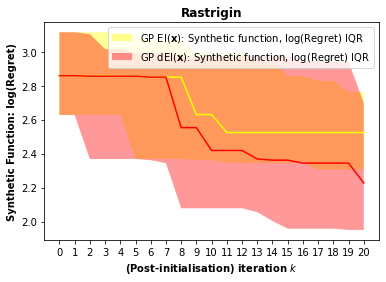

In [141]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx, color = 'Yellow')
plt.plot(median_exact, color = 'Red')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


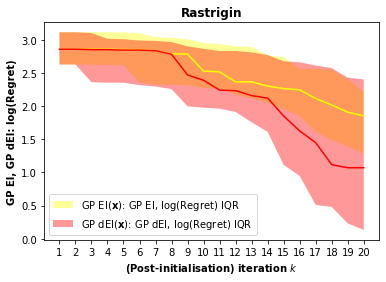

In [142]:
### Visualise!

title = obj_func

plt.figure()

plt.plot(median_approx_acqFuncMin, color = 'Yellow')
plt.plot(median_exact_acqFuncMin, color = 'Red')

xstar = np.arange(0, max_iter, step=1)
plt.fill_between(xstar, lower_approx_acqFuncMin, upper_approx_acqFuncMin, facecolor = 'Yellow', alpha=0.4, label='GP EI($\mathbf{x}$): GP EI, log(Regret) IQR')
plt.fill_between(xstar, lower_exact_acqFuncMin, upper_exact_acqFuncMin, facecolor = 'Red', alpha=0.4, label='GP dEI($\mathbf{x}$): GP dEI, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('GP EI, GP dEI: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()
